### Импортируем библиотеки

In [343]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org lightgbm

In [344]:
# pip install matplotlib==3.7.3
# pip show matplotlib
# np.version.version
# '1.26.4'
# Name: matplotlib
# Version: 3.9.2

In [345]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA 
import scipy as sp
import seaborn as sns
import math
import sklearn
import re
import matplotlib.pyplot as plt 
from sklearn.cluster import DBSCAN  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import catboost
import shap
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
import plotly.express as px
import json
import jsonlines
from sklearn.impute import SimpleImputer
import lightgbm as lgb 
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
%matplotlib inline
np.set_printoptions(precision=4)
# настраиваем показ всех столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
# формат данных float с одним знаком после запятой
pd.options.display.float_format = '{:,.5f}'.format
# отключим warnings
import warnings
warnings.filterwarnings("ignore")

# Загружаем данные

In [346]:
macro_data = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/macro.csv')
data_train = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/train.csv/train.csv')
X_check = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/test.csv/test.csv')

## Удаляем столбцы с id, так как это идентификаторы и они не представляют значимости для модели

In [347]:
data_train = data_train.drop(['ID_metro',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal', 'id'], axis=1)

# Предварительно сохраняем id для выборки без разметки
id_check = X_check['id']

X_check = X_check.drop(['ID_metro',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal', 'id'], axis=1)

## Проверяем пропущенные значения, выводим данные в процентах.

In [348]:
percent_of_nans_by_columns = pd.DataFrame(data_train.isnull().sum()/ len(data_train) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
hospital_beds_raion,47.39260
build_year,44.64901
state,44.49805
cafe_avg_price_500,43.58570
cafe_sum_500_min_price_avg,43.58570
cafe_sum_500_max_price_avg,43.58570
max_floor,31.41348
material,31.41348
num_room,31.41348
kitch_sq,31.41348


In [349]:
percent_of_nans_by_columns = pd.DataFrame(X_check.isnull().sum()/ len(X_check) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
hospital_beds_raion,44.60976
cafe_avg_price_500,41.22944
cafe_sum_500_max_price_avg,41.22944
cafe_sum_500_min_price_avg,41.22944
preschool_quota,20.83007
school_quota,20.81702
cafe_sum_1000_max_price_avg,15.94884
cafe_sum_1000_min_price_avg,15.94884
cafe_avg_price_1000,15.94884
raion_build_count_with_material_info,15.89663


In [350]:
percent_of_nans_by_columns = pd.DataFrame(macro_data.isnull().sum()/ len(macro_data) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
provision_retail_space_modern_sqm,70.61192
provision_retail_space_sqm,70.57166
modern_education_share,55.91787
old_education_build_share,55.91787
hospital_beds_available_per_cap,41.18357
hospital_bed_occupancy_per_year,41.18357
load_of_teachers_preschool_per_teacher,41.18357
grp_growth,41.18357
theaters_viewers_per_1000_cap,41.18357
museum_visitis_per_100_cap,41.18357


### Пропущенные значения присутствуют, но не в очень большом количестве. Удалять столбцы не будем, будем заполнять пропуски.

# Рассмотрим корреляцию целевого признака с другими

In [351]:
corrs = data_train.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100)

cafe_count_1000                          0.10584
cafe_sum_1500_min_price_avg              0.10464
big_road1_km                            -0.10374
cafe_sum_2000_max_price_avg              0.10299
school_education_centers_top_20_raion    0.10228
                                          ...   
cafe_sum_3000_min_price_avg              0.00512
cafe_avg_price_3000                      0.00334
cafe_sum_3000_max_price_avg              0.00220
build_year                               0.00216
trc_sqm_500                              0.00037
Name: price_doc, Length: 100, dtype: float64

In [352]:
# видим, что есть признаки с очень слабой корреляцией

In [353]:
corrs = data_train.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].head(10)

num_room              0.47634
full_sq               0.34184
sport_count_5000      0.29486
sport_count_3000      0.29065
trc_count_5000        0.28937
zd_vokzaly_avto_km   -0.28407
sadovoe_km           -0.28362
kremlin_km           -0.27925
bulvar_ring_km       -0.27916
sport_count_2000      0.27806
Name: price_doc, dtype: float64

In [354]:
# видим, что есть признаков с корреляцией больше 0.8 нет

In [355]:
toDelete = list(corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100).index)
print(toDelete[0], toDelete[-1]) # Убеждаемся, что взяли те признаки

cafe_count_1000 trc_sqm_500


# Удалим слабо скоррелированные признаки (берем по модулю менее 1.13)

In [356]:
print(data_train.shape, '\n', X_check.shape)

for col in toDelete:
    data_train.drop(col, axis=1, inplace=True)
    X_check.drop(col, axis=1, inplace=True)

print(data_train.shape, '\n', X_check.shape)

(30471, 284) 
 (7662, 283)
(30471, 184) 
 (7662, 183)


# Сформируем список столбцов с пропусками

In [357]:
missingValues = data_train.columns[data_train.isnull().any()].tolist()

pd.isnull(data_train[missingValues]).sum().sort_values(ascending=False)

hospital_beds_raion            14441
state                          13559
num_room                        9572
life_sq                         6383
build_count_brick               4991
build_count_monolith            4991
cafe_sum_1500_max_price_avg     4199
cafe_avg_price_1500             4199
floor                            167
metro_min_walk                    25
metro_km_walk                     25
railroad_station_walk_km          25
railroad_station_walk_min         25
dtype: int64

In [358]:
cols_fillna_mode = ['floor',
 'product_type',
 'num_room',
 'state',
 'hospital_beds_raion',
 'build_count_brick',
 'build_count_monolith',
 'green_part_2000']

cols_fillna_mean = ['life_sq',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500']

In [359]:
for col in cols_fillna_mode:
    data_train[col].fillna(data_train[col].mode().iloc[0],inplace=True)
    X_check[col].fillna(data_train[col].mode().iloc[0],inplace=True)

for col in cols_fillna_mean:
    data_train[col].fillna(data_train[col].mean(),inplace=True)
    X_check[col].fillna(data_train[col].mean(),inplace=True)

In [360]:
missingValues_macro = macro_data.columns[macro_data.isnull().any()].tolist()

pd.isnull(macro_data[missingValues_macro]).sum().sort_values(ascending=False)

provision_retail_space_modern_sqm    1754
provision_retail_space_sqm           1753
modern_education_share               1389
old_education_build_share            1389
theaters_viewers_per_1000_cap        1023
                                     ... 
micex_rgbi_tr                          10
brent                                   3
eurrub                                  3
usdrub                                  3
micex_cbi_tr                            1
Length: 91, dtype: int64

In [361]:
cols_fillna_mean_macro = ['provision_retail_space_modern_sqm',
 'provision_retail_space_sqm',
 'modern_education_share',
 'old_education_build_share',
 'theaters_viewers_per_1000_cap',
 'grp_growth',
 'load_of_teachers_preschool_per_teacher',
 'students_reg_sports_share',
 'population_reg_sports_share',
 'museum_visitis_per_100_cap',
  'hospital_bed_occupancy_per_year',
  'hospital_beds_available_per_cap',
  'invest_fixed_assets_phys',
  'pop_migration',
  'baths_share']

In [362]:
for col in cols_fillna_mean_macro:
    macro_data[col].fillna(macro_data[col].mode().iloc[0],inplace=True)

In [363]:
missingValues_macro = macro_data.columns[macro_data.isnull().any()].tolist()

pd.isnull(macro_data[missingValues_macro]).sum().sort_values(ascending=False)

divorce_rate             658
hot_water_share          658
share_own_revenues       658
overdue_wages_per_cap    658
fin_res_per_cap          658
                        ... 
micex_rgbi_tr             10
eurrub                     3
brent                      3
usdrub                     3
micex_cbi_tr               1
Length: 76, dtype: int64

### Заменяем некорректные символы на 0

In [364]:
# благодаря этому можно обработать данные в столбце как числовой признак
macro_data['child_on_acc_pre_school'] = macro_data['child_on_acc_pre_school'].replace('#!', 0)

In [365]:
# проверяем наличие некорректного символа после удаления
macro_data[macro_data['child_on_acc_pre_school']=='#!']

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm


### Заменяем тип данных для столбца 'child_on_acc_pre_school'
Благодаря этому можно обработать данные в столбце как числовой признак

In [366]:
macro_data['child_on_acc_pre_school']

0       45,713
1       45,713
2       45,713
3       45,713
4       45,713
         ...  
2479       NaN
2480       NaN
2481       NaN
2482       NaN
2483       NaN
Name: child_on_acc_pre_school, Length: 2484, dtype: object

In [367]:
macro_data['child_on_acc_pre_school'] = macro_data['child_on_acc_pre_school'].str.replace(',', '').astype(float)
# data_train_with_macro['child_on_acc_pre_school'] = data_train_with_macro['child_on_acc_pre_school'].round(1)

In [368]:
# проверяем, что тип данных изменился
macro_data['child_on_acc_pre_school']

0      45,713.00000
1      45,713.00000
2      45,713.00000
3      45,713.00000
4      45,713.00000
           ...     
2479            NaN
2480            NaN
2481            NaN
2482            NaN
2483            NaN
Name: child_on_acc_pre_school, Length: 2484, dtype: float64

### Исправляем явные ошибки в данных

In [369]:
# ошибка, указано 33 вместо 3. Исправляем на 3.
data_train.loc[data_train['state'] == 33, 'state'] = 3

# Смотрим описание данных

In [370]:
data_train.describe()

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,shopping_centers_raion,office_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road2_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,"30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30

### В датасете имеются категориальные данные, числовые данные и данные в формате даты.
### EDA будет производиться в зависимости от типа данных.

# Проверяем распределение целевой переменной

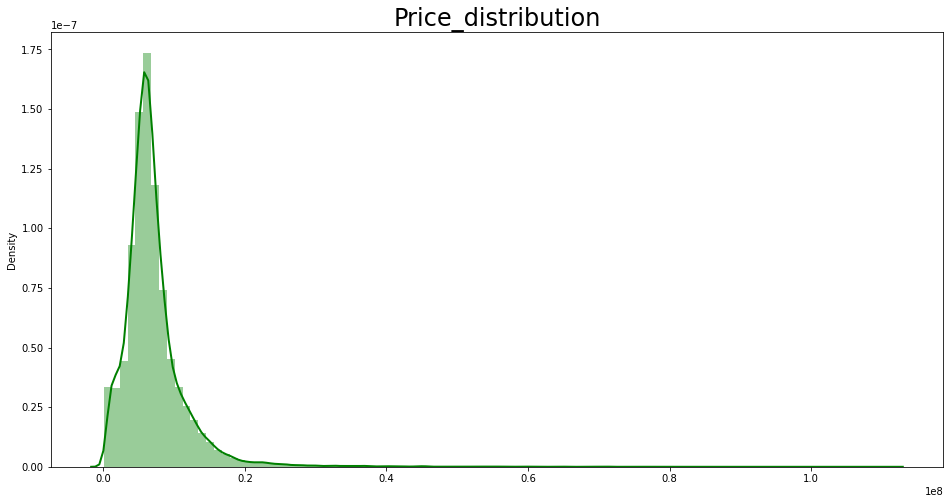

In [371]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(data_train['price_doc'].values
             , bins=100
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2})
# plt.plot(data_train_with_macro['price_doc'].values, kde=True)
plt.title('Price_distribution', fontsize=24)
plt.show()

# Распределение не является нормальным, присутствует сильное смещение. В таком случае стоит применить логарифмирование целевой переменной.

Логарифмирование в машинном обучении применяют в следующих случаях:

1. Для нормализации данных. Для алгоритмов машинного обучения важно, чтобы данные были нормально распределены, чтобы обеспечить лучшую производительность. Логарифмирование позволяет преобразовать данные в более нормальное распределение, что упрощает их анализ и моделирование. 
2. Для снижения влияния выбросов. Выбросы могут значительно влиять на алгоритмы машинного обучения, приводя к предвзятым моделям. Логарифмирование сжимает большие значения, что упрощает построение модели, в которой не доминируют экстремальные значения. 
3. Для преобразования данных для определённых видов анализа. Логарифмирование уменьшает диапазон значений и сжимает большие значения, что облегчает анализ данных с большими вариациями. 

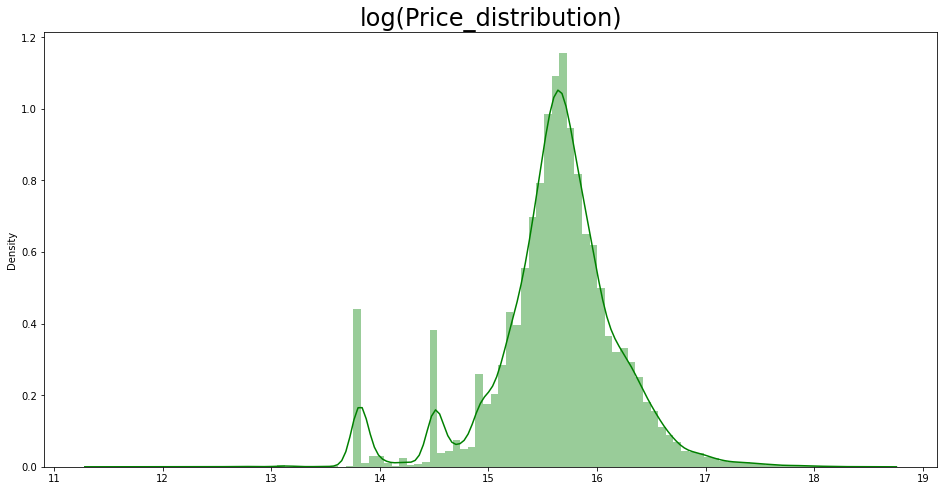

In [372]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(np.log(data_train['price_doc']).values, color = 'green', bins=100, kde=True, ax=ax)
plt.title('log(Price_distribution)', fontsize=24)
plt.show()

# Объединяем с макроэкономическими показателями

In [169]:
# data_train = data_train.merge(macro_data, on='timestamp')
# X_check = X_check.merge(macro_data, on='timestamp')
# data_train_with_macro = data_train.merge(macro_data, on='timestamp', suffixes=('_', '_macro'))
# X_check_with_macro = X_check.merge(macro_data, on='timestamp', suffixes=('_', '_macro'))

## EDA для данных в формате даты

In [373]:
def EDA_for_date_features(data):
    """переводим данные о дате в нужный формат"""
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['month'] = data.timestamp.dt.month
    data['year'] = data.timestamp.dt.year
    return data

In [374]:
data = EDA_for_date_features(data_train)

In [375]:
data_train_without_timestamp = data_train.drop('timestamp', axis=1)

In [376]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

In [378]:
def EDA_for_date_features_check(data_checked):
    ### переводим данные о дате в нужный формат
    data_checked['timestamp'] = pd.to_datetime(data_checked['timestamp'])
    data_checked['month'] = data_checked.timestamp.dt.month
    data_checked['year'] = data_checked.timestamp.dt.year
    return data_checked

In [379]:
data_checked = EDA_for_date_features_check(X_check)

In [380]:
data_checked_without_timestamp = data_checked.drop('timestamp', axis=1)

In [381]:
data_checked_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year
0,39.00000,20.70000,2,1,3.00000,Investment,Juzhnoe Butovo,"26,155,137.04000",178264,14080,11,14892,13,540.00000,1,0,13,no,4,4,no,no,no,no,no,no,no,no,30808,16251,14557,121369,59138,62231,26087,7410,18677,14080,7457,6623,14892,7839,7053,34341,18094,16247,27123,14340,12783,245.00000,116.00000,1.25896,0.73591,8.83090,0.73591,0.07850,0.74696,2.04849,4.81210,57.74522,4.85075,6.27496,0.11413,1.36960,no,19.65110,22.79099,24.07971,24.77908,no,5.70648,no,27.55349,8.42496,22.62436,16.22408,6.62008,4.12187,8.95778,8.82406,5.35367,0.22579,3.67394,11.81084,20.39243,9.13198,3.30012,25.46274,1.61315,17.21487,7.92261,2.41414,4.92361,0.51421,0.74696,0.74914,0.84830,1.91774,19.95341,14.05221,12.22858,0.44632,satisfactory,0,0,1,0,1,0,0,0,0,0,2,0,3,0,0,0,2,"

In [382]:
index_area = data_train_without_timestamp[data_train_without_timestamp['sub_area'] == 'Poselenie Klenovskoe'].index
data_train_without_timestamp.drop(index_area , inplace=True)

In [383]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

In [384]:
numerical_features = data_train_without_timestamp.dtypes[data_train_without_timestamp.dtypes != "object"].index
categorical_features = data_train_without_timestamp.dtypes[data_train_without_timestamp.dtypes == "object"].index

print("Кол-во количественных признаков: ", len(numerical_features))
print("Кол-во категориальных признаков: ", len(categorical_features))

Кол-во количественных признаков:  170
Кол-во категориальных признаков:  15


In [385]:
data_train_without_timestamp.isna().sum().sort_values(ascending=False)

full_sq                        0
cafe_count_1500_price_high     0
trc_count_1500                 0
cafe_count_1500                0
cafe_sum_1500_max_price_avg    0
                              ..
water_1line                    0
ttk_km                         0
sadovoe_km                     0
bulvar_ring_km                 0
year                           0
Length: 185, dtype: int64

In [386]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

## EDA для категориальных фичей

### Удаляем лишние пробелы справа и слева от каждого значения 

In [388]:
data_train_without_timestamp = data_train_without_timestamp.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data_checked_without_timestamp = data_checked_without_timestamp.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### Переводим yes/no в 0/1, заменяем значение no_data наиболее часто встречаемым 'poor'

In [389]:
data_train_without_timestamp.replace(to_replace=['no', 'yes'], value=[0, 1], inplace = True)
data_train_without_timestamp['ecology'].replace(to_replace=['no data'], value=['poor'], inplace = True)

In [390]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,0,16,1,0,0,0,0,0,0,0,0,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,0,10.91859,13.10062,13.67566,15.15621,0,3.83095,0,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70000,768.1800

In [391]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,0,16,1,0,0,0,0,0,0,0,0,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,0,10.91859,13.10062,13.67566,15.15621,0,3.83095,0,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70000,768.1800

In [392]:
data_checked_without_timestamp.replace(to_replace=['no', 'yes'], value=[0, 1], inplace = True)
data_checked_without_timestamp['product_type'].fillna('Investment', inplace=True)
data_checked_without_timestamp['ecology'].replace(to_replace=['no data'], value=['poor'], inplace = True)

In [393]:
data_checked_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year
0,39.00000,20.70000,2,1,3.00000,Investment,Juzhnoe Butovo,"26,155,137.04000",178264,14080,11,14892,13,540.00000,1,0,13,0,4,4,0,0,0,0,0,0,0,0,30808,16251,14557,121369,59138,62231,26087,7410,18677,14080,7457,6623,14892,7839,7053,34341,18094,16247,27123,14340,12783,245.00000,116.00000,1.25896,0.73591,8.83090,0.73591,0.07850,0.74696,2.04849,4.81210,57.74522,4.85075,6.27496,0.11413,1.36960,0,19.65110,22.79099,24.07971,24.77908,0,5.70648,0,27.55349,8.42496,22.62436,16.22408,6.62008,4.12187,8.95778,8.82406,5.35367,0.22579,3.67394,11.81084,20.39243,9.13198,3.30012,25.46274,1.61315,17.21487,7.92261,2.41414,4.92361,0.51421,0.74696,0.74914,0.84830,1.91774,19.95341,14.05221,12.22858,0.44632,satisfactory,0,0,1,0,1,0,0,0,0,0,2,0,3,0,0,0,2,"1,500.00000"

In [394]:
def EDA_for_categorial_features(data):
    """задаем тип данных object"""
    np.object = object
    """формируем список колонок, являющихся числовыми"""
    categorical_columns = data.loc[:,data.dtypes==np.object].columns
    """приводим индексы колонок к списку"""  
    cat_features = categorical_columns.tolist()
    """обрабатываем категориальные фичи и переводим их в цифровые"""  
    for col in cat_features:
        if col != 'timestamp': 
            one_hot = pd.get_dummies(data[col], prefix=col)
            data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
    """и заново определяем колонки с категориальными значениями"""   
    categorical_columns = data.loc[:,data.dtypes==np.object].columns
    cat_features = categorical_columns.tolist()
    return categorical_columns, cat_features, data

In [395]:
categorical_columns, cat_features, data = EDA_for_categorial_features(data_train_without_timestamp)

In [397]:
def EDA_for_categorial_features_check(data_checked):
    """задаем тип данных object"""
    np.object = object
    """формируем список колонок, являющихся числовыми"""
    categorical_columns_checked = data_checked.loc[:,data_checked.dtypes==np.object].columns
    """приводим индексы колонок к списку"""  
    cat_features_checked = categorical_columns_checked.tolist()
    for col in categorical_columns_checked:
        if col != 'timestamp': 
            one_hot_checked = pd.get_dummies(data_checked[col], prefix=col)
            data_checked = pd.concat((data_checked.drop(col, axis=1), one_hot_checked), axis=1)
    """и заново определяем колонки с категориальными значениями"""   
    categorical_columns_checked = data_checked.loc[:,data_checked.dtypes==np.object].columns
    cat_features_checked = categorical_columns_checked.tolist()
    return categorical_columns_checked, cat_features_checked, data_checked

In [398]:
categorical_columns_checked, cat_features_checked, data_checked = EDA_for_categorial_features_check(data_checked_without_timestamp)

## EDA для числовых фичей

In [400]:
def EDA_for_numerical_features(data):
    ### задаем тип данных object
    np.object = object
    ### формируем список колонок, являющихся числовыми
    numeric_columns = data.loc[:,data.dtypes!=np.object].columns
    ### заполняем пустые значения средним значением
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    return data

In [401]:
data = EDA_for_numerical_features(data)

In [403]:
def EDA_for_numerical_features_check(data_checked):
    ### задаем тип данных object
    np.object = object
    ### формируем список колонок, являющихся числовыми
    numeric_columns = data_checked.loc[:,data_checked.dtypes!=np.object].columns
    ### заполняем пустые значения средним значением
    for col in numeric_columns:
        data_checked[col] = data_checked[col].fillna(data_checked[col].median())
    return data_checked

In [404]:
data_checked = EDA_for_numerical_features(data_checked)

# Подготовка данных к применению модели Catboost

1. Логарифмируем y
2. Удаляем нелогарифмированное значение y
3. Формируем отдельный датасет фичей
4. Формируем отдельный датасет меток (y)

In [406]:
# логарифмируем значения y
data = data.assign(log_price_doc=np.log(data['price_doc']))
data = data.drop('price_doc', axis=1)  
# разделяем датасет на обучающую выборку и y
X_data = data.drop('log_price_doc', axis=1)
y_data = data['log_price_doc']

Функция производит следующие операции:
1. Делит датасет фичей и меток на обучающую и тестовую выборки
2. Для тестовой выборки отбирается 30% данных
3. shuffle перемешивает данные перед разделением выборки на обучающую и тестовую
4. Формат pool - это специальный формат библиотеки catboost

In [407]:
# Определяем функцию
def prepare_for_catboost_model(X_data, y_data, cat_features):
    """Функция готовит входные данные к применению модели"""
    """разделение выборки на обучающую и тестовую"""
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True,
                                                        test_size=0.3, random_state=42)
    """приведение данных к формату pool"""
    train_pool = catboost.Pool(X_train
                               ,label=y_train
                               ,cat_features=cat_features)
    test_pool = catboost.Pool(X_test
                              ,label=y_test
                              ,cat_features=cat_features)
    check_pool = catboost.Pool(data_checked
                              ,cat_features=cat_features_checked)
    """возврат данных моделью"""
    return train_pool, test_pool, check_pool, X_test, y_test, X_train, y_train

In [408]:
# Вызываем функцию
train_pool, test_pool, check_pool, X_test, y_test, X_train, y_train = prepare_for_catboost_model(X_data
                                                                                                 , y_data
                                                                                                 , cat_features)

In [410]:
# Задаем порядковый номер или название модели "_название", под которым она будет сохранена
model_number='baseline_catboost_1_50000iter'

In [409]:
# Если необходимо перезаписать модель в каталоге, предварительно очищаем каталог
!rm -rf 'catboost_clf_modelbaseline_catboost_1_50000iter'

In [411]:
# функция RMSLE - не является встроенной в библиотеку CatBoost
# Для создания собственной "кастомной метрики", необходимо представить функцию,
# вычисляющую метрику в виде объекта. Ниже представлен код на языке Python,
# вычисляющий loss_function и evaluation_metric для CatBoostRegressor.
import math
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i])))**2)

        return error_sum, weight_sum

Функция производит следующие операции:

1. Удаляет ранее обученную модель из папки
2. Определяет папку для сохранения модели
3. Инициализирует модель
4. Обучает модель
5. Сохраняет модель

In [412]:
# Определяем функцию
def catboost_model_define_and_fit(train_pool
                                  ,test_pool
                                  ,model_number):
    
    """удаляем ранее обученную модель из папки"""
    !rm -rf f'catboost_clf_model{model_number}/snapshot_model{model_number}.bkp'
    
    """задаем папку, куда сохранится обученная модель"""
    catboost_train_dir = f'catboost_clf_model{model_number}'
    
    """инициализируем модель"""
    model = CatBoostRegressor(
        iterations=50000,
        learning_rate=0.001,
        depth=6,
        eval_metric=RMSLE_val(),#параметр отвечающий за метрику обнаружения переобучения
        loss_function=RMSLE(),
        early_stopping_rounds=50,
        random_seed=42,
        train_dir=catboost_train_dir,
        verbose=10,
        use_best_model=True)
    
    """обучаем модель"""
    model.fit(
        train_pool, 
        eval_set=test_pool,
        plot=True,
        save_snapshot=True,
        snapshot_file=f'snapshot_model{model_number}.bkp')
    model.save_model(f'catboost_clf_model_{model_number}')
    """возвращаем модель для использования в следующих функциях"""
    return model

In [413]:
# Вызываем функцию
model = catboost_model_define_and_fit(train_pool
                              ,test_pool
                              ,model_number)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8068087	test: 2.8066013	best: 2.8066013 (0)	total: 675ms	remaining: 9h 22m 44s
10:	learn: 2.7790066	test: 2.7788004	best: 2.7788004 (10)	total: 798ms	remaining: 1h 25s
20:	learn: 2.7514805	test: 2.7512751	best: 2.7512751 (20)	total: 908ms	remaining: 36m 1s
30:	learn: 2.7242157	test: 2.7240113	best: 2.7240113 (30)	total: 1.01s	remaining: 27m 17s
40:	learn: 2.6972294	test: 2.6970286	best: 2.6970286 (40)	total: 1.12s	remaining: 22m 48s
50:	learn: 2.6704927	test: 2.6702955	best: 2.6702955 (50)	total: 1.26s	remaining: 20m 32s
60:	learn: 2.6440500	test: 2.6438545	best: 2.6438545 (60)	total: 1.37s	remaining: 18m 41s
70:	learn: 2.6178517	test: 2.6176583	best: 2.6176583 (70)	total: 1.48s	remaining: 17m 18s
80:	learn: 2.5919101	test: 2.5917201	best: 2.5917201 (80)	total: 1.59s	remaining: 16m 18s
90:	learn: 2.5662222	test: 2.5660351	best: 2.5660351 (90)	total: 1.69s	remaining: 15m 29s
100:	learn: 2.5407972	test: 2.5406133	best: 2.5406133 (100)	total: 1.84s	remaining: 15m 10s
110:	lear

900:	learn: 1.1493324	test: 1.1492247	best: 1.1492247 (900)	total: 11.8s	remaining: 10m 44s
910:	learn: 1.1380767	test: 1.1379692	best: 1.1379692 (910)	total: 11.9s	remaining: 10m 43s
920:	learn: 1.1269218	test: 1.1268184	best: 1.1268184 (920)	total: 12.1s	remaining: 10m 42s
930:	learn: 1.1158617	test: 1.1157588	best: 1.1157588 (930)	total: 12.2s	remaining: 10m 42s
940:	learn: 1.1049164	test: 1.1048118	best: 1.1048118 (940)	total: 12.3s	remaining: 10m 42s
950:	learn: 1.0940898	test: 1.0939838	best: 1.0939838 (950)	total: 12.4s	remaining: 10m 41s
960:	learn: 1.0833346	test: 1.0832292	best: 1.0832292 (960)	total: 12.6s	remaining: 10m 41s
970:	learn: 1.0727434	test: 1.0726374	best: 1.0726374 (970)	total: 12.7s	remaining: 10m 41s
980:	learn: 1.0622117	test: 1.0621051	best: 1.0621051 (980)	total: 12.8s	remaining: 10m 40s
990:	learn: 1.0517738	test: 1.0516683	best: 1.0516683 (990)	total: 12.9s	remaining: 10m 40s
1000:	learn: 1.0414517	test: 1.0413478	best: 1.0413478 (1000)	total: 13.1s	remai

1790:	learn: 0.4806671	test: 0.4806047	best: 0.4806047 (1790)	total: 23.2s	remaining: 10m 25s
1800:	learn: 0.4760117	test: 0.4759489	best: 0.4759489 (1800)	total: 23.4s	remaining: 10m 25s
1810:	learn: 0.4714240	test: 0.4713632	best: 0.4713632 (1810)	total: 23.5s	remaining: 10m 26s
1820:	learn: 0.4668746	test: 0.4668154	best: 0.4668154 (1820)	total: 23.7s	remaining: 10m 27s
1830:	learn: 0.4623932	test: 0.4623335	best: 0.4623335 (1830)	total: 23.9s	remaining: 10m 28s
1840:	learn: 0.4579192	test: 0.4578601	best: 0.4578601 (1840)	total: 24.1s	remaining: 10m 29s
1850:	learn: 0.4534899	test: 0.4534321	best: 0.4534321 (1850)	total: 24.2s	remaining: 10m 29s
1860:	learn: 0.4490995	test: 0.4490424	best: 0.4490424 (1860)	total: 24.3s	remaining: 10m 29s
1870:	learn: 0.4447647	test: 0.4447097	best: 0.4447097 (1870)	total: 24.5s	remaining: 10m 30s
1880:	learn: 0.4404632	test: 0.4404075	best: 0.4404075 (1880)	total: 24.6s	remaining: 10m 30s
1890:	learn: 0.4362133	test: 0.4361580	best: 0.4361580 (1890

2680:	learn: 0.2049619	test: 0.2048734	best: 0.2048734 (2680)	total: 37.3s	remaining: 10m 58s
2690:	learn: 0.2030414	test: 0.2029519	best: 0.2029519 (2690)	total: 37.5s	remaining: 10m 58s
2700:	learn: 0.2011419	test: 0.2010527	best: 0.2010527 (2700)	total: 37.7s	remaining: 11m
2710:	learn: 0.1992596	test: 0.1991694	best: 0.1991694 (2710)	total: 37.9s	remaining: 11m
2720:	learn: 0.1973998	test: 0.1973087	best: 0.1973087 (2720)	total: 38s	remaining: 11m
2730:	learn: 0.1955573	test: 0.1954655	best: 0.1954655 (2730)	total: 38.2s	remaining: 11m
2740:	learn: 0.1937375	test: 0.1936459	best: 0.1936459 (2740)	total: 38.4s	remaining: 11m 1s
2750:	learn: 0.1919455	test: 0.1918536	best: 0.1918536 (2750)	total: 38.5s	remaining: 11m 1s
2760:	learn: 0.1901564	test: 0.1900648	best: 0.1900648 (2760)	total: 38.7s	remaining: 11m 1s
2770:	learn: 0.1883828	test: 0.1882904	best: 0.1882904 (2770)	total: 38.9s	remaining: 11m 2s
2780:	learn: 0.1866427	test: 0.1865501	best: 0.1865501 (2780)	total: 39.1s	remaini

3560:	learn: 0.0935628	test: 0.0934166	best: 0.0934166 (3560)	total: 51.9s	remaining: 11m 16s
3570:	learn: 0.0927957	test: 0.0926488	best: 0.0926488 (3570)	total: 52s	remaining: 11m 16s
3580:	learn: 0.0920383	test: 0.0918907	best: 0.0918907 (3580)	total: 52.2s	remaining: 11m 16s
3590:	learn: 0.0912967	test: 0.0911475	best: 0.0911475 (3590)	total: 52.3s	remaining: 11m 16s
3600:	learn: 0.0905594	test: 0.0904107	best: 0.0904107 (3600)	total: 52.5s	remaining: 11m 15s
3610:	learn: 0.0898226	test: 0.0896725	best: 0.0896725 (3610)	total: 52.6s	remaining: 11m 15s
3620:	learn: 0.0890981	test: 0.0889472	best: 0.0889472 (3620)	total: 52.8s	remaining: 11m 15s
3630:	learn: 0.0883837	test: 0.0882322	best: 0.0882322 (3630)	total: 53s	remaining: 11m 16s
3640:	learn: 0.0876743	test: 0.0875225	best: 0.0875225 (3640)	total: 53.1s	remaining: 11m 16s
3650:	learn: 0.0869768	test: 0.0868254	best: 0.0868254 (3650)	total: 53.3s	remaining: 11m 16s
3660:	learn: 0.0862793	test: 0.0861268	best: 0.0861268 (3660)	to

4440:	learn: 0.0505711	test: 0.0503623	best: 0.0503623 (4440)	total: 1m 6s	remaining: 11m 22s
4450:	learn: 0.0503008	test: 0.0500908	best: 0.0500908 (4450)	total: 1m 6s	remaining: 11m 21s
4460:	learn: 0.0500289	test: 0.0498178	best: 0.0498178 (4460)	total: 1m 6s	remaining: 11m 21s
4470:	learn: 0.0497601	test: 0.0495477	best: 0.0495477 (4470)	total: 1m 6s	remaining: 11m 21s
4480:	learn: 0.0494910	test: 0.0492770	best: 0.0492770 (4480)	total: 1m 7s	remaining: 11m 22s
4490:	learn: 0.0492301	test: 0.0490155	best: 0.0490155 (4490)	total: 1m 7s	remaining: 11m 22s
4500:	learn: 0.0489731	test: 0.0487576	best: 0.0487576 (4500)	total: 1m 7s	remaining: 11m 22s
4510:	learn: 0.0487177	test: 0.0485010	best: 0.0485010 (4510)	total: 1m 7s	remaining: 11m 22s
4520:	learn: 0.0484660	test: 0.0482481	best: 0.0482481 (4520)	total: 1m 7s	remaining: 11m 22s
4530:	learn: 0.0482149	test: 0.0479958	best: 0.0479958 (4530)	total: 1m 7s	remaining: 11m 21s
4540:	learn: 0.0479674	test: 0.0477471	best: 0.0477471 (4540

5320:	learn: 0.0362769	test: 0.0359824	best: 0.0359824 (5320)	total: 1m 21s	remaining: 11m 25s
5330:	learn: 0.0361944	test: 0.0358992	best: 0.0358992 (5330)	total: 1m 21s	remaining: 11m 25s
5340:	learn: 0.0361149	test: 0.0358193	best: 0.0358193 (5340)	total: 1m 21s	remaining: 11m 25s
5350:	learn: 0.0360372	test: 0.0357409	best: 0.0357409 (5350)	total: 1m 22s	remaining: 11m 25s
5360:	learn: 0.0359582	test: 0.0356612	best: 0.0356612 (5360)	total: 1m 22s	remaining: 11m 25s
5370:	learn: 0.0358816	test: 0.0355838	best: 0.0355838 (5370)	total: 1m 22s	remaining: 11m 25s
5380:	learn: 0.0358049	test: 0.0355067	best: 0.0355067 (5380)	total: 1m 22s	remaining: 11m 25s
5390:	learn: 0.0357299	test: 0.0354308	best: 0.0354308 (5390)	total: 1m 22s	remaining: 11m 26s
5400:	learn: 0.0356565	test: 0.0353567	best: 0.0353567 (5400)	total: 1m 23s	remaining: 11m 26s
5410:	learn: 0.0355828	test: 0.0352826	best: 0.0352826 (5410)	total: 1m 23s	remaining: 11m 26s
5420:	learn: 0.0355126	test: 0.0352121	best: 0.035

6200:	learn: 0.0321594	test: 0.0318288	best: 0.0318288 (6200)	total: 1m 36s	remaining: 11m 20s
6210:	learn: 0.0321367	test: 0.0318059	best: 0.0318059 (6210)	total: 1m 36s	remaining: 11m 20s
6220:	learn: 0.0321133	test: 0.0317823	best: 0.0317823 (6220)	total: 1m 36s	remaining: 11m 20s
6230:	learn: 0.0320896	test: 0.0317584	best: 0.0317584 (6230)	total: 1m 36s	remaining: 11m 20s
6240:	learn: 0.0320670	test: 0.0317358	best: 0.0317358 (6240)	total: 1m 36s	remaining: 11m 20s
6250:	learn: 0.0320455	test: 0.0317143	best: 0.0317143 (6250)	total: 1m 37s	remaining: 11m 19s
6260:	learn: 0.0320243	test: 0.0316931	best: 0.0316931 (6260)	total: 1m 37s	remaining: 11m 19s
6270:	learn: 0.0320028	test: 0.0316715	best: 0.0316715 (6270)	total: 1m 37s	remaining: 11m 19s
6280:	learn: 0.0319819	test: 0.0316505	best: 0.0316505 (6280)	total: 1m 37s	remaining: 11m 20s
6290:	learn: 0.0319612	test: 0.0316298	best: 0.0316298 (6290)	total: 1m 37s	remaining: 11m 20s
6300:	learn: 0.0319394	test: 0.0316075	best: 0.031

7070:	learn: 0.0308972	test: 0.0305580	best: 0.0305580 (7070)	total: 1m 50s	remaining: 11m 13s
7080:	learn: 0.0308884	test: 0.0305490	best: 0.0305490 (7080)	total: 1m 51s	remaining: 11m 13s
7090:	learn: 0.0308801	test: 0.0305410	best: 0.0305410 (7090)	total: 1m 51s	remaining: 11m 12s
7100:	learn: 0.0308718	test: 0.0305328	best: 0.0305328 (7100)	total: 1m 51s	remaining: 11m 12s
7110:	learn: 0.0308638	test: 0.0305248	best: 0.0305248 (7110)	total: 1m 51s	remaining: 11m 12s
7120:	learn: 0.0308561	test: 0.0305169	best: 0.0305169 (7120)	total: 1m 51s	remaining: 11m 12s
7130:	learn: 0.0308480	test: 0.0305088	best: 0.0305088 (7130)	total: 1m 51s	remaining: 11m 12s
7140:	learn: 0.0308398	test: 0.0305008	best: 0.0305008 (7140)	total: 1m 52s	remaining: 11m 12s
7150:	learn: 0.0308318	test: 0.0304927	best: 0.0304927 (7150)	total: 1m 52s	remaining: 11m 12s
7160:	learn: 0.0308239	test: 0.0304850	best: 0.0304850 (7160)	total: 1m 52s	remaining: 11m 12s
7170:	learn: 0.0308156	test: 0.0304766	best: 0.030

7950:	learn: 0.0303803	test: 0.0300467	best: 0.0300467 (7950)	total: 2m 6s	remaining: 11m 9s
7960:	learn: 0.0303762	test: 0.0300429	best: 0.0300429 (7960)	total: 2m 6s	remaining: 11m 9s
7970:	learn: 0.0303720	test: 0.0300386	best: 0.0300386 (7970)	total: 2m 6s	remaining: 11m 9s
7980:	learn: 0.0303679	test: 0.0300345	best: 0.0300345 (7980)	total: 2m 7s	remaining: 11m 9s
7990:	learn: 0.0303635	test: 0.0300301	best: 0.0300301 (7990)	total: 2m 7s	remaining: 11m 9s
8000:	learn: 0.0303591	test: 0.0300257	best: 0.0300257 (8000)	total: 2m 7s	remaining: 11m 9s
8010:	learn: 0.0303555	test: 0.0300223	best: 0.0300223 (8010)	total: 2m 7s	remaining: 11m 8s
8020:	learn: 0.0303514	test: 0.0300182	best: 0.0300182 (8020)	total: 2m 7s	remaining: 11m 8s
8030:	learn: 0.0303472	test: 0.0300141	best: 0.0300141 (8030)	total: 2m 7s	remaining: 11m 8s
8040:	learn: 0.0303433	test: 0.0300103	best: 0.0300103 (8040)	total: 2m 8s	remaining: 11m 8s
8050:	learn: 0.0303395	test: 0.0300065	best: 0.0300065 (8050)	total: 2

8830:	learn: 0.0300755	test: 0.0297544	best: 0.0297544 (8830)	total: 2m 22s	remaining: 11m 3s
8840:	learn: 0.0300724	test: 0.0297513	best: 0.0297513 (8840)	total: 2m 22s	remaining: 11m 3s
8850:	learn: 0.0300695	test: 0.0297486	best: 0.0297486 (8850)	total: 2m 22s	remaining: 11m 2s
8860:	learn: 0.0300667	test: 0.0297458	best: 0.0297458 (8860)	total: 2m 22s	remaining: 11m 3s
8870:	learn: 0.0300639	test: 0.0297433	best: 0.0297433 (8870)	total: 2m 23s	remaining: 11m 3s
8880:	learn: 0.0300614	test: 0.0297409	best: 0.0297409 (8880)	total: 2m 23s	remaining: 11m 3s
8890:	learn: 0.0300586	test: 0.0297382	best: 0.0297382 (8890)	total: 2m 23s	remaining: 11m 3s
8900:	learn: 0.0300556	test: 0.0297354	best: 0.0297354 (8900)	total: 2m 23s	remaining: 11m 3s
8910:	learn: 0.0300529	test: 0.0297329	best: 0.0297329 (8910)	total: 2m 23s	remaining: 11m 2s
8920:	learn: 0.0300501	test: 0.0297301	best: 0.0297301 (8920)	total: 2m 23s	remaining: 11m 2s
8930:	learn: 0.0300475	test: 0.0297277	best: 0.0297277 (8930

9720:	learn: 0.0298522	test: 0.0295464	best: 0.0295464 (9720)	total: 2m 38s	remaining: 10m 55s
9730:	learn: 0.0298502	test: 0.0295446	best: 0.0295446 (9730)	total: 2m 38s	remaining: 10m 55s
9740:	learn: 0.0298479	test: 0.0295425	best: 0.0295425 (9740)	total: 2m 38s	remaining: 10m 54s
9750:	learn: 0.0298457	test: 0.0295404	best: 0.0295404 (9750)	total: 2m 38s	remaining: 10m 54s
9760:	learn: 0.0298435	test: 0.0295384	best: 0.0295384 (9760)	total: 2m 38s	remaining: 10m 55s
9770:	learn: 0.0298414	test: 0.0295364	best: 0.0295364 (9770)	total: 2m 39s	remaining: 10m 55s
9780:	learn: 0.0298391	test: 0.0295343	best: 0.0295343 (9780)	total: 2m 39s	remaining: 10m 54s
9790:	learn: 0.0298369	test: 0.0295322	best: 0.0295322 (9790)	total: 2m 39s	remaining: 10m 54s
9800:	learn: 0.0298343	test: 0.0295299	best: 0.0295299 (9800)	total: 2m 39s	remaining: 10m 54s
9810:	learn: 0.0298321	test: 0.0295280	best: 0.0295280 (9810)	total: 2m 39s	remaining: 10m 54s
9820:	learn: 0.0298299	test: 0.0295260	best: 0.029

10590:	learn: 0.0296701	test: 0.0293818	best: 0.0293818 (10590)	total: 2m 53s	remaining: 10m 46s
10600:	learn: 0.0296680	test: 0.0293799	best: 0.0293799 (10600)	total: 2m 53s	remaining: 10m 46s
10610:	learn: 0.0296659	test: 0.0293780	best: 0.0293780 (10610)	total: 2m 54s	remaining: 10m 45s
10620:	learn: 0.0296639	test: 0.0293763	best: 0.0293763 (10620)	total: 2m 54s	remaining: 10m 45s
10630:	learn: 0.0296619	test: 0.0293746	best: 0.0293746 (10630)	total: 2m 54s	remaining: 10m 45s
10640:	learn: 0.0296601	test: 0.0293729	best: 0.0293729 (10640)	total: 2m 54s	remaining: 10m 45s
10650:	learn: 0.0296582	test: 0.0293712	best: 0.0293712 (10650)	total: 2m 54s	remaining: 10m 45s
10660:	learn: 0.0296561	test: 0.0293692	best: 0.0293692 (10660)	total: 2m 55s	remaining: 10m 45s
10670:	learn: 0.0296538	test: 0.0293669	best: 0.0293669 (10670)	total: 2m 55s	remaining: 10m 45s
10680:	learn: 0.0296521	test: 0.0293654	best: 0.0293654 (10680)	total: 2m 55s	remaining: 10m 45s
10690:	learn: 0.0296502	test: 

11460:	learn: 0.0295180	test: 0.0292481	best: 0.0292481 (11460)	total: 3m 9s	remaining: 10m 36s
11470:	learn: 0.0295165	test: 0.0292468	best: 0.0292468 (11470)	total: 3m 9s	remaining: 10m 36s
11480:	learn: 0.0295150	test: 0.0292455	best: 0.0292455 (11480)	total: 3m 9s	remaining: 10m 37s
11490:	learn: 0.0295136	test: 0.0292444	best: 0.0292444 (11490)	total: 3m 10s	remaining: 10m 37s
11500:	learn: 0.0295122	test: 0.0292432	best: 0.0292432 (11500)	total: 3m 10s	remaining: 10m 36s
11510:	learn: 0.0295105	test: 0.0292420	best: 0.0292420 (11510)	total: 3m 10s	remaining: 10m 36s
11520:	learn: 0.0295086	test: 0.0292404	best: 0.0292404 (11520)	total: 3m 10s	remaining: 10m 36s
11530:	learn: 0.0295070	test: 0.0292391	best: 0.0292391 (11530)	total: 3m 10s	remaining: 10m 36s
11540:	learn: 0.0295055	test: 0.0292377	best: 0.0292377 (11540)	total: 3m 10s	remaining: 10m 36s
11550:	learn: 0.0295040	test: 0.0292364	best: 0.0292364 (11550)	total: 3m 11s	remaining: 10m 36s
11560:	learn: 0.0295024	test: 0.0

12310:	learn: 0.0293999	test: 0.0291489	best: 0.0291489 (12310)	total: 3m 24s	remaining: 10m 27s
12320:	learn: 0.0293988	test: 0.0291479	best: 0.0291479 (12320)	total: 3m 25s	remaining: 10m 27s
12330:	learn: 0.0293974	test: 0.0291469	best: 0.0291469 (12330)	total: 3m 25s	remaining: 10m 27s
12340:	learn: 0.0293959	test: 0.0291457	best: 0.0291457 (12340)	total: 3m 25s	remaining: 10m 27s
12350:	learn: 0.0293947	test: 0.0291446	best: 0.0291446 (12350)	total: 3m 25s	remaining: 10m 27s
12360:	learn: 0.0293935	test: 0.0291435	best: 0.0291435 (12360)	total: 3m 25s	remaining: 10m 26s
12370:	learn: 0.0293923	test: 0.0291426	best: 0.0291426 (12370)	total: 3m 26s	remaining: 10m 26s
12380:	learn: 0.0293911	test: 0.0291416	best: 0.0291416 (12380)	total: 3m 26s	remaining: 10m 26s
12390:	learn: 0.0293899	test: 0.0291406	best: 0.0291406 (12390)	total: 3m 26s	remaining: 10m 27s
12400:	learn: 0.0293885	test: 0.0291395	best: 0.0291395 (12400)	total: 3m 26s	remaining: 10m 26s
12410:	learn: 0.0293872	test: 

13170:	learn: 0.0293003	test: 0.0290688	best: 0.0290688 (13170)	total: 3m 41s	remaining: 10m 18s
13180:	learn: 0.0292990	test: 0.0290679	best: 0.0290679 (13180)	total: 3m 41s	remaining: 10m 17s
13190:	learn: 0.0292979	test: 0.0290671	best: 0.0290671 (13190)	total: 3m 41s	remaining: 10m 17s
13200:	learn: 0.0292969	test: 0.0290663	best: 0.0290663 (13200)	total: 3m 41s	remaining: 10m 17s
13210:	learn: 0.0292959	test: 0.0290654	best: 0.0290654 (13210)	total: 3m 41s	remaining: 10m 18s
13220:	learn: 0.0292946	test: 0.0290644	best: 0.0290644 (13220)	total: 3m 42s	remaining: 10m 18s
13230:	learn: 0.0292935	test: 0.0290636	best: 0.0290636 (13230)	total: 3m 42s	remaining: 10m 17s
13240:	learn: 0.0292925	test: 0.0290627	best: 0.0290627 (13240)	total: 3m 42s	remaining: 10m 17s
13250:	learn: 0.0292913	test: 0.0290620	best: 0.0290620 (13250)	total: 3m 42s	remaining: 10m 17s
13260:	learn: 0.0292903	test: 0.0290611	best: 0.0290611 (13260)	total: 3m 42s	remaining: 10m 17s
13270:	learn: 0.0292891	test: 

14020:	learn: 0.0291984	test: 0.0290005	best: 0.0290005 (14020)	total: 3m 57s	remaining: 10m 9s
14030:	learn: 0.0291974	test: 0.0289999	best: 0.0289999 (14030)	total: 3m 57s	remaining: 10m 9s
14040:	learn: 0.0291961	test: 0.0289991	best: 0.0289991 (14040)	total: 3m 57s	remaining: 10m 9s
14050:	learn: 0.0291952	test: 0.0289985	best: 0.0289985 (14050)	total: 3m 58s	remaining: 10m 9s
14060:	learn: 0.0291940	test: 0.0289978	best: 0.0289978 (14060)	total: 3m 58s	remaining: 10m 8s
14070:	learn: 0.0291929	test: 0.0289971	best: 0.0289971 (14070)	total: 3m 58s	remaining: 10m 8s
14080:	learn: 0.0291921	test: 0.0289965	best: 0.0289965 (14080)	total: 3m 58s	remaining: 10m 8s
14090:	learn: 0.0291910	test: 0.0289959	best: 0.0289959 (14090)	total: 3m 58s	remaining: 10m 8s
14100:	learn: 0.0291899	test: 0.0289953	best: 0.0289953 (14100)	total: 3m 59s	remaining: 10m 8s
14110:	learn: 0.0291889	test: 0.0289945	best: 0.0289945 (14110)	total: 3m 59s	remaining: 10m 8s
14120:	learn: 0.0291879	test: 0.0289939	

14900:	learn: 0.0291005	test: 0.0289405	best: 0.0289405 (14900)	total: 4m 14s	remaining: 9m 58s
14910:	learn: 0.0290990	test: 0.0289396	best: 0.0289396 (14910)	total: 4m 14s	remaining: 9m 58s
14920:	learn: 0.0290978	test: 0.0289386	best: 0.0289386 (14920)	total: 4m 14s	remaining: 9m 57s
14930:	learn: 0.0290968	test: 0.0289380	best: 0.0289380 (14930)	total: 4m 14s	remaining: 9m 58s
14940:	learn: 0.0290957	test: 0.0289373	best: 0.0289373 (14940)	total: 4m 14s	remaining: 9m 58s
14950:	learn: 0.0290947	test: 0.0289367	best: 0.0289367 (14950)	total: 4m 15s	remaining: 9m 58s
14960:	learn: 0.0290937	test: 0.0289361	best: 0.0289361 (14960)	total: 4m 15s	remaining: 9m 57s
14970:	learn: 0.0290924	test: 0.0289353	best: 0.0289353 (14970)	total: 4m 15s	remaining: 9m 57s
14980:	learn: 0.0290914	test: 0.0289346	best: 0.0289346 (14980)	total: 4m 15s	remaining: 9m 57s
14990:	learn: 0.0290904	test: 0.0289340	best: 0.0289340 (14990)	total: 4m 15s	remaining: 9m 57s
15000:	learn: 0.0290893	test: 0.0289332	

15770:	learn: 0.0290225	test: 0.0288909	best: 0.0288909 (15770)	total: 4m 31s	remaining: 9m 48s
15780:	learn: 0.0290219	test: 0.0288905	best: 0.0288905 (15780)	total: 4m 31s	remaining: 9m 48s
15790:	learn: 0.0290213	test: 0.0288900	best: 0.0288900 (15790)	total: 4m 31s	remaining: 9m 48s
15800:	learn: 0.0290208	test: 0.0288897	best: 0.0288897 (15800)	total: 4m 31s	remaining: 9m 47s
15810:	learn: 0.0290203	test: 0.0288895	best: 0.0288895 (15810)	total: 4m 31s	remaining: 9m 47s
15820:	learn: 0.0290196	test: 0.0288891	best: 0.0288891 (15819)	total: 4m 32s	remaining: 9m 48s
15830:	learn: 0.0290189	test: 0.0288888	best: 0.0288888 (15830)	total: 4m 32s	remaining: 9m 47s
15840:	learn: 0.0290183	test: 0.0288884	best: 0.0288884 (15840)	total: 4m 32s	remaining: 9m 47s
15850:	learn: 0.0290178	test: 0.0288879	best: 0.0288879 (15850)	total: 4m 32s	remaining: 9m 47s
15860:	learn: 0.0290173	test: 0.0288877	best: 0.0288877 (15860)	total: 4m 32s	remaining: 9m 47s
15870:	learn: 0.0290168	test: 0.0288874	

16640:	learn: 0.0289700	test: 0.0288574	best: 0.0288574 (16640)	total: 4m 47s	remaining: 9m 37s
16650:	learn: 0.0289693	test: 0.0288570	best: 0.0288570 (16650)	total: 4m 48s	remaining: 9m 36s
16660:	learn: 0.0289687	test: 0.0288566	best: 0.0288566 (16660)	total: 4m 48s	remaining: 9m 37s
16670:	learn: 0.0289682	test: 0.0288563	best: 0.0288563 (16670)	total: 4m 48s	remaining: 9m 37s
16680:	learn: 0.0289676	test: 0.0288559	best: 0.0288559 (16680)	total: 4m 48s	remaining: 9m 37s
16690:	learn: 0.0289671	test: 0.0288556	best: 0.0288556 (16690)	total: 4m 49s	remaining: 9m 36s
16700:	learn: 0.0289665	test: 0.0288552	best: 0.0288552 (16700)	total: 4m 49s	remaining: 9m 36s
16710:	learn: 0.0289659	test: 0.0288548	best: 0.0288548 (16710)	total: 4m 49s	remaining: 9m 36s
16720:	learn: 0.0289650	test: 0.0288542	best: 0.0288542 (16720)	total: 4m 49s	remaining: 9m 36s
16730:	learn: 0.0289644	test: 0.0288538	best: 0.0288538 (16730)	total: 4m 49s	remaining: 9m 36s
16740:	learn: 0.0289638	test: 0.0288534	

17500:	learn: 0.0289045	test: 0.0288179	best: 0.0288179 (17500)	total: 5m 5s	remaining: 9m 27s
17510:	learn: 0.0289036	test: 0.0288175	best: 0.0288175 (17510)	total: 5m 5s	remaining: 9m 27s
17520:	learn: 0.0289030	test: 0.0288172	best: 0.0288172 (17520)	total: 5m 5s	remaining: 9m 27s
17530:	learn: 0.0289024	test: 0.0288168	best: 0.0288168 (17530)	total: 5m 6s	remaining: 9m 26s
17540:	learn: 0.0289016	test: 0.0288163	best: 0.0288163 (17540)	total: 5m 6s	remaining: 9m 26s
17550:	learn: 0.0289008	test: 0.0288160	best: 0.0288160 (17550)	total: 5m 6s	remaining: 9m 27s
17560:	learn: 0.0289000	test: 0.0288154	best: 0.0288154 (17560)	total: 5m 6s	remaining: 9m 26s
17570:	learn: 0.0288994	test: 0.0288151	best: 0.0288151 (17570)	total: 5m 7s	remaining: 9m 26s
17580:	learn: 0.0288987	test: 0.0288147	best: 0.0288147 (17580)	total: 5m 7s	remaining: 9m 26s
17590:	learn: 0.0288977	test: 0.0288141	best: 0.0288141 (17590)	total: 5m 7s	remaining: 9m 26s
17600:	learn: 0.0288970	test: 0.0288136	best: 0.02

18370:	learn: 0.0288426	test: 0.0287840	best: 0.0287840 (18370)	total: 5m 24s	remaining: 9m 18s
18380:	learn: 0.0288420	test: 0.0287836	best: 0.0287836 (18380)	total: 5m 24s	remaining: 9m 17s
18390:	learn: 0.0288413	test: 0.0287833	best: 0.0287833 (18390)	total: 5m 24s	remaining: 9m 17s
18400:	learn: 0.0288405	test: 0.0287829	best: 0.0287829 (18400)	total: 5m 24s	remaining: 9m 17s
18410:	learn: 0.0288400	test: 0.0287827	best: 0.0287827 (18410)	total: 5m 25s	remaining: 9m 17s
18420:	learn: 0.0288393	test: 0.0287823	best: 0.0287823 (18420)	total: 5m 25s	remaining: 9m 17s
18430:	learn: 0.0288387	test: 0.0287819	best: 0.0287819 (18430)	total: 5m 25s	remaining: 9m 17s
18440:	learn: 0.0288381	test: 0.0287815	best: 0.0287815 (18440)	total: 5m 25s	remaining: 9m 17s
18450:	learn: 0.0288373	test: 0.0287813	best: 0.0287813 (18450)	total: 5m 25s	remaining: 9m 16s
18460:	learn: 0.0288368	test: 0.0287809	best: 0.0287809 (18460)	total: 5m 25s	remaining: 9m 16s
18470:	learn: 0.0288362	test: 0.0287808	

19240:	learn: 0.0287883	test: 0.0287585	best: 0.0287585 (19240)	total: 5m 42s	remaining: 9m 7s
19250:	learn: 0.0287878	test: 0.0287582	best: 0.0287582 (19250)	total: 5m 42s	remaining: 9m 7s
19260:	learn: 0.0287871	test: 0.0287579	best: 0.0287579 (19260)	total: 5m 42s	remaining: 9m 7s
19270:	learn: 0.0287866	test: 0.0287576	best: 0.0287576 (19270)	total: 5m 42s	remaining: 9m 6s
19280:	learn: 0.0287860	test: 0.0287574	best: 0.0287574 (19280)	total: 5m 43s	remaining: 9m 6s
19290:	learn: 0.0287853	test: 0.0287571	best: 0.0287571 (19290)	total: 5m 43s	remaining: 9m 6s
19300:	learn: 0.0287847	test: 0.0287569	best: 0.0287569 (19300)	total: 5m 43s	remaining: 9m 6s
19310:	learn: 0.0287842	test: 0.0287567	best: 0.0287567 (19310)	total: 5m 43s	remaining: 9m 6s
19320:	learn: 0.0287834	test: 0.0287564	best: 0.0287564 (19320)	total: 5m 44s	remaining: 9m 6s
19330:	learn: 0.0287829	test: 0.0287562	best: 0.0287562 (19330)	total: 5m 44s	remaining: 9m 6s
19340:	learn: 0.0287823	test: 0.0287559	best: 0.02

20120:	learn: 0.0287329	test: 0.0287334	best: 0.0287334 (20120)	total: 6m	remaining: 8m 55s
20130:	learn: 0.0287322	test: 0.0287331	best: 0.0287331 (20130)	total: 6m	remaining: 8m 54s
20140:	learn: 0.0287317	test: 0.0287328	best: 0.0287328 (20140)	total: 6m	remaining: 8m 54s
20150:	learn: 0.0287310	test: 0.0287325	best: 0.0287325 (20150)	total: 6m 1s	remaining: 8m 55s
20160:	learn: 0.0287304	test: 0.0287322	best: 0.0287322 (20160)	total: 6m 1s	remaining: 8m 54s
20170:	learn: 0.0287296	test: 0.0287318	best: 0.0287318 (20170)	total: 6m 1s	remaining: 8m 54s
20180:	learn: 0.0287290	test: 0.0287315	best: 0.0287315 (20180)	total: 6m 1s	remaining: 8m 54s
20190:	learn: 0.0287284	test: 0.0287313	best: 0.0287313 (20190)	total: 6m 1s	remaining: 8m 54s
20200:	learn: 0.0287278	test: 0.0287310	best: 0.0287310 (20200)	total: 6m 1s	remaining: 8m 53s
20210:	learn: 0.0287271	test: 0.0287308	best: 0.0287308 (20210)	total: 6m 2s	remaining: 8m 53s
20220:	learn: 0.0287265	test: 0.0287305	best: 0.0287305 (20

20980:	learn: 0.0286806	test: 0.0287101	best: 0.0287101 (20980)	total: 6m 18s	remaining: 8m 44s
20990:	learn: 0.0286801	test: 0.0287098	best: 0.0287098 (20990)	total: 6m 19s	remaining: 8m 43s
21000:	learn: 0.0286794	test: 0.0287096	best: 0.0287096 (21000)	total: 6m 19s	remaining: 8m 43s
21010:	learn: 0.0286789	test: 0.0287093	best: 0.0287093 (21010)	total: 6m 19s	remaining: 8m 43s
21020:	learn: 0.0286785	test: 0.0287091	best: 0.0287091 (21020)	total: 6m 19s	remaining: 8m 43s
21030:	learn: 0.0286780	test: 0.0287088	best: 0.0287088 (21030)	total: 6m 20s	remaining: 8m 43s
21040:	learn: 0.0286774	test: 0.0287085	best: 0.0287085 (21040)	total: 6m 20s	remaining: 8m 43s
21050:	learn: 0.0286769	test: 0.0287084	best: 0.0287084 (21050)	total: 6m 20s	remaining: 8m 43s
21060:	learn: 0.0286763	test: 0.0287081	best: 0.0287081 (21060)	total: 6m 20s	remaining: 8m 42s
21070:	learn: 0.0286755	test: 0.0287076	best: 0.0287076 (21070)	total: 6m 20s	remaining: 8m 42s
21080:	learn: 0.0286750	test: 0.0287073	

21850:	learn: 0.0286308	test: 0.0286892	best: 0.0286892 (21850)	total: 6m 37s	remaining: 8m 31s
21860:	learn: 0.0286303	test: 0.0286890	best: 0.0286890 (21860)	total: 6m 37s	remaining: 8m 32s
21870:	learn: 0.0286299	test: 0.0286887	best: 0.0286887 (21870)	total: 6m 37s	remaining: 8m 31s
21880:	learn: 0.0286291	test: 0.0286885	best: 0.0286885 (21880)	total: 6m 38s	remaining: 8m 31s
21890:	learn: 0.0286285	test: 0.0286883	best: 0.0286883 (21890)	total: 6m 38s	remaining: 8m 31s
21900:	learn: 0.0286280	test: 0.0286880	best: 0.0286880 (21900)	total: 6m 38s	remaining: 8m 31s
21910:	learn: 0.0286274	test: 0.0286877	best: 0.0286877 (21910)	total: 6m 38s	remaining: 8m 30s
21920:	learn: 0.0286268	test: 0.0286875	best: 0.0286875 (21920)	total: 6m 38s	remaining: 8m 30s
21930:	learn: 0.0286263	test: 0.0286874	best: 0.0286874 (21928)	total: 6m 39s	remaining: 8m 31s
21940:	learn: 0.0286258	test: 0.0286872	best: 0.0286872 (21939)	total: 6m 39s	remaining: 8m 30s
21950:	learn: 0.0286253	test: 0.0286870	

22720:	learn: 0.0285887	test: 0.0286724	best: 0.0286724 (22720)	total: 6m 55s	remaining: 8m 19s
22730:	learn: 0.0285881	test: 0.0286722	best: 0.0286722 (22730)	total: 6m 55s	remaining: 8m 19s
22740:	learn: 0.0285877	test: 0.0286720	best: 0.0286720 (22740)	total: 6m 56s	remaining: 8m 18s
22750:	learn: 0.0285873	test: 0.0286719	best: 0.0286719 (22749)	total: 6m 56s	remaining: 8m 18s
22760:	learn: 0.0285868	test: 0.0286717	best: 0.0286717 (22760)	total: 6m 56s	remaining: 8m 18s
22770:	learn: 0.0285864	test: 0.0286716	best: 0.0286716 (22769)	total: 6m 57s	remaining: 8m 18s
22780:	learn: 0.0285861	test: 0.0286715	best: 0.0286715 (22780)	total: 6m 57s	remaining: 8m 18s
22790:	learn: 0.0285856	test: 0.0286713	best: 0.0286713 (22790)	total: 6m 57s	remaining: 8m 18s
22800:	learn: 0.0285852	test: 0.0286712	best: 0.0286712 (22800)	total: 6m 57s	remaining: 8m 18s
22810:	learn: 0.0285846	test: 0.0286709	best: 0.0286709 (22809)	total: 6m 57s	remaining: 8m 17s
22820:	learn: 0.0285842	test: 0.0286708	

23590:	learn: 0.0285478	test: 0.0286564	best: 0.0286564 (23590)	total: 7m 15s	remaining: 8m 7s
23600:	learn: 0.0285474	test: 0.0286562	best: 0.0286562 (23600)	total: 7m 15s	remaining: 8m 6s
23610:	learn: 0.0285468	test: 0.0286560	best: 0.0286560 (23610)	total: 7m 15s	remaining: 8m 6s
23620:	learn: 0.0285464	test: 0.0286558	best: 0.0286558 (23619)	total: 7m 15s	remaining: 8m 6s
23630:	learn: 0.0285460	test: 0.0286557	best: 0.0286557 (23630)	total: 7m 15s	remaining: 8m 6s
23640:	learn: 0.0285453	test: 0.0286553	best: 0.0286553 (23640)	total: 7m 15s	remaining: 8m 5s
23650:	learn: 0.0285448	test: 0.0286551	best: 0.0286551 (23650)	total: 7m 16s	remaining: 8m 5s
23660:	learn: 0.0285443	test: 0.0286549	best: 0.0286549 (23660)	total: 7m 16s	remaining: 8m 6s
23670:	learn: 0.0285437	test: 0.0286547	best: 0.0286547 (23670)	total: 7m 16s	remaining: 8m 5s
23680:	learn: 0.0285432	test: 0.0286545	best: 0.0286545 (23680)	total: 7m 16s	remaining: 8m 5s
23690:	learn: 0.0285426	test: 0.0286542	best: 0.02

24460:	learn: 0.0284988	test: 0.0286349	best: 0.0286349 (24460)	total: 7m 33s	remaining: 7m 53s
24470:	learn: 0.0284981	test: 0.0286347	best: 0.0286347 (24470)	total: 7m 33s	remaining: 7m 53s
24480:	learn: 0.0284975	test: 0.0286344	best: 0.0286344 (24480)	total: 7m 34s	remaining: 7m 53s
24490:	learn: 0.0284970	test: 0.0286342	best: 0.0286342 (24490)	total: 7m 34s	remaining: 7m 53s
24500:	learn: 0.0284964	test: 0.0286339	best: 0.0286339 (24500)	total: 7m 34s	remaining: 7m 53s
24510:	learn: 0.0284960	test: 0.0286338	best: 0.0286338 (24510)	total: 7m 35s	remaining: 7m 53s
24520:	learn: 0.0284955	test: 0.0286335	best: 0.0286335 (24520)	total: 7m 35s	remaining: 7m 53s
24530:	learn: 0.0284950	test: 0.0286334	best: 0.0286334 (24530)	total: 7m 35s	remaining: 7m 52s
24540:	learn: 0.0284943	test: 0.0286331	best: 0.0286331 (24540)	total: 7m 35s	remaining: 7m 52s
24550:	learn: 0.0284937	test: 0.0286329	best: 0.0286329 (24550)	total: 7m 35s	remaining: 7m 52s
24560:	learn: 0.0284931	test: 0.0286325	

25330:	learn: 0.0284485	test: 0.0286149	best: 0.0286149 (25330)	total: 7m 53s	remaining: 7m 41s
25340:	learn: 0.0284479	test: 0.0286147	best: 0.0286147 (25340)	total: 7m 53s	remaining: 7m 40s
25350:	learn: 0.0284474	test: 0.0286145	best: 0.0286145 (25350)	total: 7m 53s	remaining: 7m 40s
25360:	learn: 0.0284467	test: 0.0286143	best: 0.0286143 (25360)	total: 7m 53s	remaining: 7m 40s
25370:	learn: 0.0284462	test: 0.0286140	best: 0.0286140 (25370)	total: 7m 54s	remaining: 7m 40s
25380:	learn: 0.0284457	test: 0.0286139	best: 0.0286139 (25380)	total: 7m 54s	remaining: 7m 40s
25390:	learn: 0.0284451	test: 0.0286137	best: 0.0286137 (25390)	total: 7m 54s	remaining: 7m 40s
25400:	learn: 0.0284444	test: 0.0286134	best: 0.0286134 (25400)	total: 7m 55s	remaining: 7m 40s
25410:	learn: 0.0284439	test: 0.0286132	best: 0.0286132 (25410)	total: 7m 55s	remaining: 7m 39s
25420:	learn: 0.0284434	test: 0.0286131	best: 0.0286131 (25419)	total: 7m 55s	remaining: 7m 39s
25430:	learn: 0.0284426	test: 0.0286128	

26190:	learn: 0.0284042	test: 0.0285980	best: 0.0285980 (26190)	total: 8m 13s	remaining: 7m 28s
26200:	learn: 0.0284037	test: 0.0285978	best: 0.0285978 (26200)	total: 8m 13s	remaining: 7m 28s
26210:	learn: 0.0284034	test: 0.0285977	best: 0.0285977 (26209)	total: 8m 13s	remaining: 7m 27s
26220:	learn: 0.0284029	test: 0.0285976	best: 0.0285976 (26220)	total: 8m 13s	remaining: 7m 27s
26230:	learn: 0.0284024	test: 0.0285973	best: 0.0285973 (26230)	total: 8m 13s	remaining: 7m 27s
26240:	learn: 0.0284018	test: 0.0285971	best: 0.0285971 (26240)	total: 8m 14s	remaining: 7m 27s
26250:	learn: 0.0284014	test: 0.0285971	best: 0.0285971 (26250)	total: 8m 14s	remaining: 7m 27s
26260:	learn: 0.0284010	test: 0.0285970	best: 0.0285970 (26260)	total: 8m 14s	remaining: 7m 27s
26270:	learn: 0.0284005	test: 0.0285968	best: 0.0285968 (26270)	total: 8m 15s	remaining: 7m 27s
26280:	learn: 0.0284001	test: 0.0285967	best: 0.0285967 (26280)	total: 8m 15s	remaining: 7m 26s
26290:	learn: 0.0283995	test: 0.0285965	

27050:	learn: 0.0283730	test: 0.0285875	best: 0.0285875 (27048)	total: 8m 33s	remaining: 7m 15s
27060:	learn: 0.0283727	test: 0.0285874	best: 0.0285874 (27060)	total: 8m 33s	remaining: 7m 15s
27070:	learn: 0.0283724	test: 0.0285873	best: 0.0285873 (27068)	total: 8m 34s	remaining: 7m 15s
27080:	learn: 0.0283721	test: 0.0285872	best: 0.0285872 (27079)	total: 8m 34s	remaining: 7m 15s
27090:	learn: 0.0283718	test: 0.0285872	best: 0.0285872 (27090)	total: 8m 34s	remaining: 7m 14s
27100:	learn: 0.0283717	test: 0.0285871	best: 0.0285871 (27099)	total: 8m 34s	remaining: 7m 14s
27110:	learn: 0.0283713	test: 0.0285870	best: 0.0285870 (27110)	total: 8m 34s	remaining: 7m 14s
27120:	learn: 0.0283708	test: 0.0285868	best: 0.0285868 (27118)	total: 8m 35s	remaining: 7m 14s
27130:	learn: 0.0283705	test: 0.0285867	best: 0.0285867 (27130)	total: 8m 35s	remaining: 7m 14s
27140:	learn: 0.0283703	test: 0.0285866	best: 0.0285866 (27140)	total: 8m 35s	remaining: 7m 14s
27150:	learn: 0.0283700	test: 0.0285865	

27910:	learn: 0.0283464	test: 0.0285787	best: 0.0285787 (27910)	total: 8m 53s	remaining: 7m 2s
27920:	learn: 0.0283462	test: 0.0285787	best: 0.0285787 (27919)	total: 8m 53s	remaining: 7m 2s
27930:	learn: 0.0283460	test: 0.0285786	best: 0.0285786 (27930)	total: 8m 53s	remaining: 7m 1s
27940:	learn: 0.0283458	test: 0.0285786	best: 0.0285786 (27940)	total: 8m 53s	remaining: 7m 1s
27950:	learn: 0.0283454	test: 0.0285785	best: 0.0285785 (27950)	total: 8m 54s	remaining: 7m 1s
27960:	learn: 0.0283453	test: 0.0285784	best: 0.0285784 (27959)	total: 8m 54s	remaining: 7m 1s
27970:	learn: 0.0283449	test: 0.0285784	best: 0.0285784 (27969)	total: 8m 54s	remaining: 7m 1s
27980:	learn: 0.0283447	test: 0.0285783	best: 0.0285783 (27980)	total: 8m 55s	remaining: 7m 1s
27990:	learn: 0.0283443	test: 0.0285781	best: 0.0285781 (27990)	total: 8m 55s	remaining: 7m
28000:	learn: 0.0283442	test: 0.0285781	best: 0.0285781 (28000)	total: 8m 55s	remaining: 7m
28010:	learn: 0.0283439	test: 0.0285780	best: 0.0285780 

28790:	learn: 0.0283223	test: 0.0285712	best: 0.0285712 (28790)	total: 9m 14s	remaining: 6m 48s
28800:	learn: 0.0283220	test: 0.0285711	best: 0.0285711 (28800)	total: 9m 14s	remaining: 6m 48s
28810:	learn: 0.0283218	test: 0.0285710	best: 0.0285710 (28810)	total: 9m 14s	remaining: 6m 48s
28820:	learn: 0.0283216	test: 0.0285709	best: 0.0285709 (28819)	total: 9m 15s	remaining: 6m 47s
28830:	learn: 0.0283214	test: 0.0285709	best: 0.0285709 (28830)	total: 9m 15s	remaining: 6m 47s
28840:	learn: 0.0283211	test: 0.0285708	best: 0.0285708 (28840)	total: 9m 16s	remaining: 6m 47s
28850:	learn: 0.0283209	test: 0.0285708	best: 0.0285708 (28850)	total: 9m 16s	remaining: 6m 47s
28860:	learn: 0.0283206	test: 0.0285706	best: 0.0285706 (28860)	total: 9m 16s	remaining: 6m 47s
28870:	learn: 0.0283203	test: 0.0285706	best: 0.0285706 (28870)	total: 9m 16s	remaining: 6m 47s
28880:	learn: 0.0283199	test: 0.0285704	best: 0.0285704 (28877)	total: 9m 16s	remaining: 6m 47s
28890:	learn: 0.0283195	test: 0.0285703	

29650:	learn: 0.0282986	test: 0.0285638	best: 0.0285638 (29650)	total: 9m 34s	remaining: 6m 34s
29660:	learn: 0.0282983	test: 0.0285638	best: 0.0285638 (29660)	total: 9m 34s	remaining: 6m 33s
29670:	learn: 0.0282981	test: 0.0285637	best: 0.0285637 (29669)	total: 9m 34s	remaining: 6m 33s
29680:	learn: 0.0282978	test: 0.0285636	best: 0.0285636 (29680)	total: 9m 34s	remaining: 6m 33s
29690:	learn: 0.0282977	test: 0.0285636	best: 0.0285636 (29690)	total: 9m 35s	remaining: 6m 33s
29700:	learn: 0.0282974	test: 0.0285634	best: 0.0285634 (29700)	total: 9m 35s	remaining: 6m 33s
29710:	learn: 0.0282970	test: 0.0285633	best: 0.0285633 (29710)	total: 9m 35s	remaining: 6m 33s
29720:	learn: 0.0282968	test: 0.0285632	best: 0.0285632 (29720)	total: 9m 35s	remaining: 6m 32s
29730:	learn: 0.0282966	test: 0.0285632	best: 0.0285632 (29730)	total: 9m 35s	remaining: 6m 32s
29740:	learn: 0.0282964	test: 0.0285631	best: 0.0285631 (29740)	total: 9m 36s	remaining: 6m 32s
29750:	learn: 0.0282962	test: 0.0285631	

30510:	learn: 0.0282733	test: 0.0285565	best: 0.0285565 (30510)	total: 9m 54s	remaining: 6m 19s
30520:	learn: 0.0282732	test: 0.0285565	best: 0.0285565 (30519)	total: 9m 54s	remaining: 6m 19s
30530:	learn: 0.0282728	test: 0.0285563	best: 0.0285563 (30530)	total: 9m 54s	remaining: 6m 19s
30540:	learn: 0.0282725	test: 0.0285562	best: 0.0285562 (30540)	total: 9m 55s	remaining: 6m 19s
30550:	learn: 0.0282721	test: 0.0285560	best: 0.0285560 (30549)	total: 9m 55s	remaining: 6m 19s
30560:	learn: 0.0282719	test: 0.0285560	best: 0.0285560 (30560)	total: 9m 55s	remaining: 6m 18s
30570:	learn: 0.0282717	test: 0.0285559	best: 0.0285559 (30567)	total: 9m 55s	remaining: 6m 18s
30580:	learn: 0.0282712	test: 0.0285558	best: 0.0285558 (30580)	total: 9m 55s	remaining: 6m 18s
30590:	learn: 0.0282709	test: 0.0285557	best: 0.0285557 (30590)	total: 9m 56s	remaining: 6m 18s
30600:	learn: 0.0282708	test: 0.0285557	best: 0.0285557 (30597)	total: 9m 56s	remaining: 6m 17s
30610:	learn: 0.0282704	test: 0.0285556	

31370:	learn: 0.0282490	test: 0.0285496	best: 0.0285496 (31368)	total: 10m 14s	remaining: 6m 5s
31380:	learn: 0.0282488	test: 0.0285496	best: 0.0285496 (31379)	total: 10m 15s	remaining: 6m 5s
31390:	learn: 0.0282486	test: 0.0285495	best: 0.0285495 (31389)	total: 10m 15s	remaining: 6m 4s
31400:	learn: 0.0282482	test: 0.0285494	best: 0.0285494 (31400)	total: 10m 15s	remaining: 6m 4s
31410:	learn: 0.0282480	test: 0.0285494	best: 0.0285494 (31410)	total: 10m 15s	remaining: 6m 4s
31420:	learn: 0.0282476	test: 0.0285493	best: 0.0285493 (31417)	total: 10m 15s	remaining: 6m 4s
31430:	learn: 0.0282471	test: 0.0285492	best: 0.0285492 (31429)	total: 10m 16s	remaining: 6m 4s
31440:	learn: 0.0282470	test: 0.0285492	best: 0.0285492 (31436)	total: 10m 16s	remaining: 6m 3s
31450:	learn: 0.0282467	test: 0.0285491	best: 0.0285491 (31445)	total: 10m 17s	remaining: 6m 3s
31460:	learn: 0.0282465	test: 0.0285490	best: 0.0285490 (31459)	total: 10m 17s	remaining: 6m 3s
31470:	learn: 0.0282463	test: 0.0285489	

32240:	learn: 0.0282229	test: 0.0285418	best: 0.0285418 (32240)	total: 10m 36s	remaining: 5m 50s
32250:	learn: 0.0282226	test: 0.0285417	best: 0.0285417 (32250)	total: 10m 36s	remaining: 5m 50s
32260:	learn: 0.0282223	test: 0.0285416	best: 0.0285416 (32260)	total: 10m 36s	remaining: 5m 50s
32270:	learn: 0.0282220	test: 0.0285415	best: 0.0285415 (32269)	total: 10m 37s	remaining: 5m 50s
32280:	learn: 0.0282216	test: 0.0285415	best: 0.0285415 (32280)	total: 10m 37s	remaining: 5m 50s
32290:	learn: 0.0282214	test: 0.0285415	best: 0.0285415 (32289)	total: 10m 38s	remaining: 5m 49s
32300:	learn: 0.0282211	test: 0.0285414	best: 0.0285414 (32298)	total: 10m 38s	remaining: 5m 49s
32310:	learn: 0.0282209	test: 0.0285413	best: 0.0285413 (32310)	total: 10m 38s	remaining: 5m 49s
32320:	learn: 0.0282207	test: 0.0285413	best: 0.0285413 (32320)	total: 10m 38s	remaining: 5m 49s
32330:	learn: 0.0282204	test: 0.0285412	best: 0.0285412 (32330)	total: 10m 39s	remaining: 5m 49s
32340:	learn: 0.0282199	test: 

33100:	learn: 0.0281945	test: 0.0285339	best: 0.0285339 (33100)	total: 10m 58s	remaining: 5m 36s
33110:	learn: 0.0281941	test: 0.0285337	best: 0.0285337 (33110)	total: 10m 58s	remaining: 5m 36s
33120:	learn: 0.0281939	test: 0.0285336	best: 0.0285336 (33120)	total: 10m 58s	remaining: 5m 35s
33130:	learn: 0.0281936	test: 0.0285336	best: 0.0285336 (33129)	total: 10m 59s	remaining: 5m 35s
33140:	learn: 0.0281932	test: 0.0285335	best: 0.0285335 (33140)	total: 10m 59s	remaining: 5m 35s
33150:	learn: 0.0281930	test: 0.0285334	best: 0.0285334 (33149)	total: 10m 59s	remaining: 5m 35s
33160:	learn: 0.0281925	test: 0.0285333	best: 0.0285333 (33159)	total: 11m	remaining: 5m 35s
33170:	learn: 0.0281922	test: 0.0285332	best: 0.0285332 (33170)	total: 11m	remaining: 5m 34s
33180:	learn: 0.0281917	test: 0.0285330	best: 0.0285330 (33180)	total: 11m	remaining: 5m 34s
33190:	learn: 0.0281915	test: 0.0285330	best: 0.0285330 (33190)	total: 11m	remaining: 5m 34s
33200:	learn: 0.0281911	test: 0.0285328	best: 

33960:	learn: 0.0281669	test: 0.0285269	best: 0.0285269 (33960)	total: 11m 19s	remaining: 5m 20s
33970:	learn: 0.0281666	test: 0.0285268	best: 0.0285268 (33970)	total: 11m 19s	remaining: 5m 20s
33980:	learn: 0.0281662	test: 0.0285266	best: 0.0285266 (33980)	total: 11m 20s	remaining: 5m 20s
33990:	learn: 0.0281659	test: 0.0285265	best: 0.0285265 (33989)	total: 11m 20s	remaining: 5m 20s
34000:	learn: 0.0281654	test: 0.0285265	best: 0.0285265 (33996)	total: 11m 20s	remaining: 5m 20s
34010:	learn: 0.0281650	test: 0.0285263	best: 0.0285263 (34010)	total: 11m 21s	remaining: 5m 20s
34020:	learn: 0.0281647	test: 0.0285262	best: 0.0285262 (34020)	total: 11m 21s	remaining: 5m 19s
34030:	learn: 0.0281645	test: 0.0285262	best: 0.0285262 (34030)	total: 11m 21s	remaining: 5m 19s
34040:	learn: 0.0281643	test: 0.0285262	best: 0.0285262 (34038)	total: 11m 21s	remaining: 5m 19s
34050:	learn: 0.0281641	test: 0.0285261	best: 0.0285261 (34050)	total: 11m 22s	remaining: 5m 19s
34060:	learn: 0.0281637	test: 

34820:	learn: 0.0281368	test: 0.0285194	best: 0.0285194 (34820)	total: 11m 42s	remaining: 5m 6s
34830:	learn: 0.0281364	test: 0.0285193	best: 0.0285193 (34830)	total: 11m 43s	remaining: 5m 6s
34840:	learn: 0.0281361	test: 0.0285191	best: 0.0285191 (34840)	total: 11m 43s	remaining: 5m 5s
34850:	learn: 0.0281357	test: 0.0285190	best: 0.0285190 (34850)	total: 11m 43s	remaining: 5m 5s
34860:	learn: 0.0281353	test: 0.0285189	best: 0.0285189 (34860)	total: 11m 43s	remaining: 5m 5s
34870:	learn: 0.0281349	test: 0.0285188	best: 0.0285188 (34870)	total: 11m 43s	remaining: 5m 5s
34880:	learn: 0.0281345	test: 0.0285187	best: 0.0285187 (34878)	total: 11m 43s	remaining: 5m 5s
34890:	learn: 0.0281341	test: 0.0285186	best: 0.0285186 (34890)	total: 11m 44s	remaining: 5m 5s
34900:	learn: 0.0281339	test: 0.0285186	best: 0.0285186 (34899)	total: 11m 44s	remaining: 5m 4s
34910:	learn: 0.0281337	test: 0.0285185	best: 0.0285185 (34910)	total: 11m 44s	remaining: 5m 4s
34920:	learn: 0.0281334	test: 0.0285184	

35680:	learn: 0.0281075	test: 0.0285113	best: 0.0285113 (35680)	total: 12m 4s	remaining: 4m 50s
35690:	learn: 0.0281074	test: 0.0285113	best: 0.0285113 (35680)	total: 12m 4s	remaining: 4m 50s
35700:	learn: 0.0281069	test: 0.0285111	best: 0.0285111 (35700)	total: 12m 4s	remaining: 4m 50s
35710:	learn: 0.0281067	test: 0.0285111	best: 0.0285111 (35708)	total: 12m 4s	remaining: 4m 49s
35720:	learn: 0.0281063	test: 0.0285110	best: 0.0285110 (35720)	total: 12m 4s	remaining: 4m 49s
35730:	learn: 0.0281060	test: 0.0285109	best: 0.0285109 (35729)	total: 12m 5s	remaining: 4m 49s
35740:	learn: 0.0281057	test: 0.0285109	best: 0.0285109 (35740)	total: 12m 5s	remaining: 4m 49s
35750:	learn: 0.0281054	test: 0.0285108	best: 0.0285108 (35749)	total: 12m 5s	remaining: 4m 49s
35760:	learn: 0.0281052	test: 0.0285107	best: 0.0285107 (35756)	total: 12m 6s	remaining: 4m 49s
35770:	learn: 0.0281047	test: 0.0285106	best: 0.0285106 (35770)	total: 12m 6s	remaining: 4m 48s
35780:	learn: 0.0281043	test: 0.0285104	

36530:	learn: 0.0280794	test: 0.0285040	best: 0.0285040 (36530)	total: 12m 26s	remaining: 4m 35s
36540:	learn: 0.0280791	test: 0.0285039	best: 0.0285039 (36540)	total: 12m 26s	remaining: 4m 35s
36550:	learn: 0.0280788	test: 0.0285038	best: 0.0285038 (36550)	total: 12m 26s	remaining: 4m 34s
36560:	learn: 0.0280786	test: 0.0285037	best: 0.0285037 (36560)	total: 12m 27s	remaining: 4m 34s
36570:	learn: 0.0280781	test: 0.0285037	best: 0.0285037 (36570)	total: 12m 27s	remaining: 4m 34s
36580:	learn: 0.0280777	test: 0.0285035	best: 0.0285035 (36580)	total: 12m 27s	remaining: 4m 34s
36590:	learn: 0.0280773	test: 0.0285035	best: 0.0285035 (36590)	total: 12m 27s	remaining: 4m 33s
36600:	learn: 0.0280770	test: 0.0285034	best: 0.0285034 (36600)	total: 12m 28s	remaining: 4m 34s
36610:	learn: 0.0280767	test: 0.0285034	best: 0.0285034 (36610)	total: 12m 28s	remaining: 4m 33s
36620:	learn: 0.0280762	test: 0.0285032	best: 0.0285032 (36620)	total: 12m 28s	remaining: 4m 33s
36630:	learn: 0.0280757	test: 

37390:	learn: 0.0280471	test: 0.0284969	best: 0.0284969 (37390)	total: 12m 48s	remaining: 4m 18s
37400:	learn: 0.0280468	test: 0.0284968	best: 0.0284968 (37400)	total: 12m 48s	remaining: 4m 18s
37410:	learn: 0.0280465	test: 0.0284967	best: 0.0284967 (37410)	total: 12m 48s	remaining: 4m 18s
37420:	learn: 0.0280462	test: 0.0284966	best: 0.0284966 (37420)	total: 12m 48s	remaining: 4m 18s
37430:	learn: 0.0280458	test: 0.0284965	best: 0.0284965 (37430)	total: 12m 48s	remaining: 4m 18s
37440:	learn: 0.0280455	test: 0.0284964	best: 0.0284964 (37440)	total: 12m 49s	remaining: 4m 18s
37450:	learn: 0.0280452	test: 0.0284964	best: 0.0284964 (37449)	total: 12m 49s	remaining: 4m 17s
37460:	learn: 0.0280449	test: 0.0284963	best: 0.0284963 (37460)	total: 12m 49s	remaining: 4m 17s
37470:	learn: 0.0280445	test: 0.0284962	best: 0.0284962 (37469)	total: 12m 50s	remaining: 4m 17s
37480:	learn: 0.0280442	test: 0.0284961	best: 0.0284961 (37479)	total: 12m 50s	remaining: 4m 17s
37490:	learn: 0.0280440	test: 

38250:	learn: 0.0280202	test: 0.0284908	best: 0.0284908 (38243)	total: 13m 9s	remaining: 4m 2s
38260:	learn: 0.0280199	test: 0.0284908	best: 0.0284908 (38260)	total: 13m 9s	remaining: 4m 2s
38270:	learn: 0.0280196	test: 0.0284907	best: 0.0284907 (38270)	total: 13m 10s	remaining: 4m 2s
38280:	learn: 0.0280194	test: 0.0284906	best: 0.0284906 (38280)	total: 13m 10s	remaining: 4m 1s
38290:	learn: 0.0280191	test: 0.0284906	best: 0.0284906 (38290)	total: 13m 10s	remaining: 4m 1s
38300:	learn: 0.0280189	test: 0.0284906	best: 0.0284906 (38290)	total: 13m 11s	remaining: 4m 1s
38310:	learn: 0.0280184	test: 0.0284905	best: 0.0284905 (38308)	total: 13m 11s	remaining: 4m 1s
38320:	learn: 0.0280181	test: 0.0284904	best: 0.0284904 (38320)	total: 13m 11s	remaining: 4m 1s
38330:	learn: 0.0280178	test: 0.0284903	best: 0.0284903 (38330)	total: 13m 11s	remaining: 4m
38340:	learn: 0.0280176	test: 0.0284903	best: 0.0284903 (38340)	total: 13m 11s	remaining: 4m
38350:	learn: 0.0280174	test: 0.0284903	best: 0.

39110:	learn: 0.0279966	test: 0.0284858	best: 0.0284858 (39108)	total: 13m 31s	remaining: 3m 45s
39120:	learn: 0.0279963	test: 0.0284858	best: 0.0284858 (39120)	total: 13m 31s	remaining: 3m 45s
39130:	learn: 0.0279959	test: 0.0284857	best: 0.0284857 (39130)	total: 13m 31s	remaining: 3m 45s
39140:	learn: 0.0279958	test: 0.0284857	best: 0.0284857 (39137)	total: 13m 31s	remaining: 3m 45s
39150:	learn: 0.0279955	test: 0.0284856	best: 0.0284856 (39150)	total: 13m 31s	remaining: 3m 44s
39160:	learn: 0.0279952	test: 0.0284855	best: 0.0284855 (39160)	total: 13m 32s	remaining: 3m 44s
39170:	learn: 0.0279950	test: 0.0284855	best: 0.0284855 (39170)	total: 13m 32s	remaining: 3m 44s
39180:	learn: 0.0279946	test: 0.0284854	best: 0.0284854 (39179)	total: 13m 33s	remaining: 3m 44s
39190:	learn: 0.0279943	test: 0.0284853	best: 0.0284853 (39190)	total: 13m 33s	remaining: 3m 44s
39200:	learn: 0.0279941	test: 0.0284852	best: 0.0284852 (39199)	total: 13m 33s	remaining: 3m 44s
39210:	learn: 0.0279938	test: 

39960:	learn: 0.0279738	test: 0.0284809	best: 0.0284809 (39955)	total: 13m 52s	remaining: 3m 29s
39970:	learn: 0.0279736	test: 0.0284809	best: 0.0284809 (39968)	total: 13m 53s	remaining: 3m 29s
39980:	learn: 0.0279733	test: 0.0284808	best: 0.0284808 (39980)	total: 13m 53s	remaining: 3m 28s
39990:	learn: 0.0279730	test: 0.0284808	best: 0.0284808 (39990)	total: 13m 53s	remaining: 3m 28s
40000:	learn: 0.0279728	test: 0.0284808	best: 0.0284808 (39993)	total: 13m 53s	remaining: 3m 28s
40010:	learn: 0.0279725	test: 0.0284807	best: 0.0284807 (40010)	total: 13m 54s	remaining: 3m 28s
40020:	learn: 0.0279724	test: 0.0284807	best: 0.0284807 (40019)	total: 13m 54s	remaining: 3m 28s
40030:	learn: 0.0279721	test: 0.0284806	best: 0.0284806 (40030)	total: 13m 54s	remaining: 3m 27s
40040:	learn: 0.0279719	test: 0.0284806	best: 0.0284806 (40038)	total: 13m 54s	remaining: 3m 27s
40050:	learn: 0.0279717	test: 0.0284805	best: 0.0284805 (40050)	total: 13m 55s	remaining: 3m 27s
40060:	learn: 0.0279715	test: 

40820:	learn: 0.0279525	test: 0.0284766	best: 0.0284766 (40817)	total: 14m 15s	remaining: 3m 12s
40830:	learn: 0.0279522	test: 0.0284766	best: 0.0284766 (40826)	total: 14m 15s	remaining: 3m 12s
40840:	learn: 0.0279519	test: 0.0284765	best: 0.0284765 (40836)	total: 14m 15s	remaining: 3m 11s
40850:	learn: 0.0279515	test: 0.0284765	best: 0.0284765 (40850)	total: 14m 15s	remaining: 3m 11s
40860:	learn: 0.0279512	test: 0.0284765	best: 0.0284765 (40860)	total: 14m 16s	remaining: 3m 11s
40870:	learn: 0.0279509	test: 0.0284764	best: 0.0284764 (40869)	total: 14m 16s	remaining: 3m 11s
40880:	learn: 0.0279507	test: 0.0284763	best: 0.0284763 (40880)	total: 14m 16s	remaining: 3m 11s
40890:	learn: 0.0279505	test: 0.0284763	best: 0.0284763 (40890)	total: 14m 16s	remaining: 3m 10s
40900:	learn: 0.0279502	test: 0.0284762	best: 0.0284762 (40900)	total: 14m 17s	remaining: 3m 10s
40910:	learn: 0.0279501	test: 0.0284762	best: 0.0284762 (40910)	total: 14m 17s	remaining: 3m 10s
40920:	learn: 0.0279500	test: 

41690:	learn: 0.0279332	test: 0.0284725	best: 0.0284725 (41690)	total: 14m 37s	remaining: 2m 54s
41700:	learn: 0.0279330	test: 0.0284724	best: 0.0284724 (41695)	total: 14m 37s	remaining: 2m 54s
41710:	learn: 0.0279328	test: 0.0284724	best: 0.0284724 (41710)	total: 14m 38s	remaining: 2m 54s
41720:	learn: 0.0279325	test: 0.0284724	best: 0.0284724 (41719)	total: 14m 38s	remaining: 2m 54s
41730:	learn: 0.0279323	test: 0.0284724	best: 0.0284724 (41726)	total: 14m 38s	remaining: 2m 54s
41740:	learn: 0.0279321	test: 0.0284724	best: 0.0284724 (41732)	total: 14m 39s	remaining: 2m 53s
41750:	learn: 0.0279319	test: 0.0284723	best: 0.0284723 (41749)	total: 14m 39s	remaining: 2m 53s
41760:	learn: 0.0279316	test: 0.0284723	best: 0.0284723 (41759)	total: 14m 39s	remaining: 2m 53s
41770:	learn: 0.0279313	test: 0.0284722	best: 0.0284722 (41770)	total: 14m 39s	remaining: 2m 53s
41780:	learn: 0.0279311	test: 0.0284721	best: 0.0284721 (41779)	total: 14m 40s	remaining: 2m 53s
41790:	learn: 0.0279309	test: 

42550:	learn: 0.0279135	test: 0.0284686	best: 0.0284686 (42550)	total: 15m	remaining: 2m 37s
42560:	learn: 0.0279132	test: 0.0284686	best: 0.0284686 (42560)	total: 15m 1s	remaining: 2m 37s
42570:	learn: 0.0279131	test: 0.0284685	best: 0.0284685 (42570)	total: 15m 1s	remaining: 2m 37s
42580:	learn: 0.0279129	test: 0.0284685	best: 0.0284684 (42573)	total: 15m 1s	remaining: 2m 37s
42590:	learn: 0.0279126	test: 0.0284684	best: 0.0284684 (42590)	total: 15m 1s	remaining: 2m 36s
42600:	learn: 0.0279124	test: 0.0284682	best: 0.0284682 (42600)	total: 15m 1s	remaining: 2m 36s
42610:	learn: 0.0279121	test: 0.0284682	best: 0.0284682 (42610)	total: 15m 1s	remaining: 2m 36s
42620:	learn: 0.0279118	test: 0.0284680	best: 0.0284680 (42620)	total: 15m 2s	remaining: 2m 36s
42630:	learn: 0.0279116	test: 0.0284680	best: 0.0284680 (42629)	total: 15m 3s	remaining: 2m 36s
42640:	learn: 0.0279112	test: 0.0284679	best: 0.0284679 (42640)	total: 15m 3s	remaining: 2m 35s
42650:	learn: 0.0279110	test: 0.0284678	bes

43400:	learn: 0.0278906	test: 0.0284634	best: 0.0284634 (43398)	total: 15m 24s	remaining: 2m 20s
43410:	learn: 0.0278905	test: 0.0284633	best: 0.0284633 (43407)	total: 15m 24s	remaining: 2m 20s
43420:	learn: 0.0278902	test: 0.0284632	best: 0.0284632 (43420)	total: 15m 24s	remaining: 2m 20s
43430:	learn: 0.0278900	test: 0.0284632	best: 0.0284632 (43430)	total: 15m 24s	remaining: 2m 19s
43440:	learn: 0.0278898	test: 0.0284631	best: 0.0284631 (43440)	total: 15m 24s	remaining: 2m 19s
43450:	learn: 0.0278895	test: 0.0284631	best: 0.0284631 (43440)	total: 15m 24s	remaining: 2m 19s
43460:	learn: 0.0278892	test: 0.0284630	best: 0.0284630 (43459)	total: 15m 25s	remaining: 2m 19s
43470:	learn: 0.0278890	test: 0.0284630	best: 0.0284630 (43470)	total: 15m 25s	remaining: 2m 19s
43480:	learn: 0.0278889	test: 0.0284630	best: 0.0284630 (43474)	total: 15m 26s	remaining: 2m 18s
43490:	learn: 0.0278886	test: 0.0284629	best: 0.0284629 (43490)	total: 15m 26s	remaining: 2m 18s
43500:	learn: 0.0278883	test: 

44260:	learn: 0.0278685	test: 0.0284586	best: 0.0284586 (44251)	total: 15m 47s	remaining: 2m 2s
44270:	learn: 0.0278683	test: 0.0284585	best: 0.0284585 (44270)	total: 15m 47s	remaining: 2m 2s
44280:	learn: 0.0278680	test: 0.0284585	best: 0.0284585 (44280)	total: 15m 47s	remaining: 2m 2s
44290:	learn: 0.0278677	test: 0.0284584	best: 0.0284584 (44289)	total: 15m 47s	remaining: 2m 2s
44300:	learn: 0.0278673	test: 0.0284583	best: 0.0284583 (44300)	total: 15m 47s	remaining: 2m 1s
44310:	learn: 0.0278670	test: 0.0284583	best: 0.0284583 (44308)	total: 15m 48s	remaining: 2m 1s
44320:	learn: 0.0278667	test: 0.0284582	best: 0.0284582 (44318)	total: 15m 48s	remaining: 2m 1s
44330:	learn: 0.0278665	test: 0.0284582	best: 0.0284582 (44330)	total: 15m 49s	remaining: 2m 1s
44340:	learn: 0.0278661	test: 0.0284581	best: 0.0284581 (44339)	total: 15m 49s	remaining: 2m 1s
44350:	learn: 0.0278658	test: 0.0284581	best: 0.0284581 (44350)	total: 15m 49s	remaining: 2m
44360:	learn: 0.0278656	test: 0.0284580	bes

45120:	learn: 0.0278438	test: 0.0284540	best: 0.0284540 (45120)	total: 16m 10s	remaining: 1m 44s
45130:	learn: 0.0278436	test: 0.0284539	best: 0.0284539 (45129)	total: 16m 10s	remaining: 1m 44s
45140:	learn: 0.0278433	test: 0.0284539	best: 0.0284539 (45139)	total: 16m 10s	remaining: 1m 44s
45150:	learn: 0.0278428	test: 0.0284537	best: 0.0284537 (45150)	total: 16m 11s	remaining: 1m 44s
45160:	learn: 0.0278425	test: 0.0284537	best: 0.0284537 (45152)	total: 16m 11s	remaining: 1m 44s
45170:	learn: 0.0278422	test: 0.0284537	best: 0.0284537 (45152)	total: 16m 11s	remaining: 1m 43s
45180:	learn: 0.0278418	test: 0.0284537	best: 0.0284537 (45180)	total: 16m 12s	remaining: 1m 43s
45190:	learn: 0.0278415	test: 0.0284537	best: 0.0284537 (45188)	total: 16m 12s	remaining: 1m 43s
45200:	learn: 0.0278411	test: 0.0284536	best: 0.0284536 (45199)	total: 16m 12s	remaining: 1m 43s
45210:	learn: 0.0278408	test: 0.0284535	best: 0.0284535 (45209)	total: 16m 12s	remaining: 1m 43s
45220:	learn: 0.0278405	test: 

45970:	learn: 0.0278193	test: 0.0284498	best: 0.0284498 (45970)	total: 16m 33s	remaining: 1m 27s
45980:	learn: 0.0278188	test: 0.0284497	best: 0.0284497 (45979)	total: 16m 34s	remaining: 1m 26s
45990:	learn: 0.0278186	test: 0.0284497	best: 0.0284497 (45983)	total: 16m 34s	remaining: 1m 26s
46000:	learn: 0.0278182	test: 0.0284496	best: 0.0284496 (45998)	total: 16m 34s	remaining: 1m 26s
46010:	learn: 0.0278178	test: 0.0284495	best: 0.0284495 (46009)	total: 16m 35s	remaining: 1m 26s
46020:	learn: 0.0278175	test: 0.0284495	best: 0.0284495 (46017)	total: 16m 35s	remaining: 1m 26s
46030:	learn: 0.0278173	test: 0.0284494	best: 0.0284494 (46030)	total: 16m 35s	remaining: 1m 25s
46040:	learn: 0.0278171	test: 0.0284495	best: 0.0284494 (46036)	total: 16m 35s	remaining: 1m 25s
46050:	learn: 0.0278169	test: 0.0284494	best: 0.0284494 (46036)	total: 16m 36s	remaining: 1m 25s
46060:	learn: 0.0278166	test: 0.0284494	best: 0.0284494 (46060)	total: 16m 36s	remaining: 1m 25s
46070:	learn: 0.0278164	test: 

46830:	learn: 0.0277941	test: 0.0284454	best: 0.0284454 (46826)	total: 16m 58s	remaining: 1m 8s
46840:	learn: 0.0277938	test: 0.0284453	best: 0.0284453 (46834)	total: 16m 58s	remaining: 1m 8s
46850:	learn: 0.0277935	test: 0.0284452	best: 0.0284452 (46850)	total: 16m 58s	remaining: 1m 8s
46860:	learn: 0.0277933	test: 0.0284452	best: 0.0284452 (46860)	total: 16m 58s	remaining: 1m 8s
46870:	learn: 0.0277930	test: 0.0284451	best: 0.0284451 (46869)	total: 16m 59s	remaining: 1m 8s
46880:	learn: 0.0277928	test: 0.0284451	best: 0.0284451 (46880)	total: 17m	remaining: 1m 7s
46890:	learn: 0.0277927	test: 0.0284451	best: 0.0284451 (46888)	total: 17m	remaining: 1m 7s
46900:	learn: 0.0277923	test: 0.0284450	best: 0.0284450 (46900)	total: 17m	remaining: 1m 7s
46910:	learn: 0.0277920	test: 0.0284450	best: 0.0284450 (46904)	total: 17m	remaining: 1m 7s
46920:	learn: 0.0277917	test: 0.0284449	best: 0.0284449 (46919)	total: 17m	remaining: 1m 6s
46930:	learn: 0.0277914	test: 0.0284448	best: 0.0284448 (469

47700:	learn: 0.0277688	test: 0.0284413	best: 0.0284413 (47699)	total: 17m 23s	remaining: 50.3s
47710:	learn: 0.0277685	test: 0.0284413	best: 0.0284413 (47710)	total: 17m 23s	remaining: 50.1s
47720:	learn: 0.0277682	test: 0.0284412	best: 0.0284412 (47719)	total: 17m 24s	remaining: 49.9s
47730:	learn: 0.0277679	test: 0.0284412	best: 0.0284412 (47730)	total: 17m 24s	remaining: 49.6s
47740:	learn: 0.0277677	test: 0.0284411	best: 0.0284411 (47740)	total: 17m 24s	remaining: 49.4s
47750:	learn: 0.0277674	test: 0.0284411	best: 0.0284411 (47745)	total: 17m 24s	remaining: 49.2s
47760:	learn: 0.0277672	test: 0.0284410	best: 0.0284410 (47760)	total: 17m 24s	remaining: 49s
47770:	learn: 0.0277671	test: 0.0284410	best: 0.0284410 (47768)	total: 17m 25s	remaining: 48.8s
47780:	learn: 0.0277669	test: 0.0284410	best: 0.0284410 (47768)	total: 17m 25s	remaining: 48.6s
47790:	learn: 0.0277665	test: 0.0284410	best: 0.0284410 (47790)	total: 17m 26s	remaining: 48.4s
47800:	learn: 0.0277661	test: 0.0284410	be

48560:	learn: 0.0277434	test: 0.0284374	best: 0.0284374 (48558)	total: 17m 47s	remaining: 31.6s
48570:	learn: 0.0277433	test: 0.0284374	best: 0.0284374 (48568)	total: 17m 47s	remaining: 31.4s
48580:	learn: 0.0277430	test: 0.0284373	best: 0.0284373 (48580)	total: 17m 47s	remaining: 31.2s
48590:	learn: 0.0277427	test: 0.0284372	best: 0.0284372 (48590)	total: 17m 47s	remaining: 31s
48600:	learn: 0.0277424	test: 0.0284372	best: 0.0284372 (48600)	total: 17m 47s	remaining: 30.7s
48610:	learn: 0.0277419	test: 0.0284371	best: 0.0284371 (48610)	total: 17m 48s	remaining: 30.5s
48620:	learn: 0.0277418	test: 0.0284371	best: 0.0284371 (48610)	total: 17m 49s	remaining: 30.3s
48630:	learn: 0.0277414	test: 0.0284371	best: 0.0284371 (48629)	total: 17m 49s	remaining: 30.1s
48640:	learn: 0.0277411	test: 0.0284370	best: 0.0284370 (48639)	total: 17m 49s	remaining: 29.9s
48650:	learn: 0.0277408	test: 0.0284370	best: 0.0284370 (48650)	total: 17m 49s	remaining: 29.7s
48660:	learn: 0.0277405	test: 0.0284369	be

49430:	learn: 0.0277170	test: 0.0284333	best: 0.0284333 (49430)	total: 18m 12s	remaining: 12.6s
49440:	learn: 0.0277167	test: 0.0284332	best: 0.0284332 (49438)	total: 18m 13s	remaining: 12.4s
49450:	learn: 0.0277164	test: 0.0284331	best: 0.0284331 (49449)	total: 18m 13s	remaining: 12.1s
49460:	learn: 0.0277162	test: 0.0284331	best: 0.0284331 (49460)	total: 18m 13s	remaining: 11.9s
49470:	learn: 0.0277159	test: 0.0284331	best: 0.0284331 (49465)	total: 18m 13s	remaining: 11.7s
49480:	learn: 0.0277157	test: 0.0284331	best: 0.0284331 (49478)	total: 18m 13s	remaining: 11.5s
49490:	learn: 0.0277155	test: 0.0284330	best: 0.0284330 (49486)	total: 18m 14s	remaining: 11.3s
49500:	learn: 0.0277151	test: 0.0284330	best: 0.0284330 (49499)	total: 18m 14s	remaining: 11s
49510:	learn: 0.0277149	test: 0.0284330	best: 0.0284330 (49510)	total: 18m 15s	remaining: 10.8s
49520:	learn: 0.0277147	test: 0.0284330	best: 0.0284330 (49516)	total: 18m 15s	remaining: 10.6s
49530:	learn: 0.0277144	test: 0.0284329	be

Функция позволяет:

1. Увидеть график снижения ошибки на обучающей и тестовой выборке
2. Оценить наличие переобучения (например, если ошибка на обучающей выборке продолжает снижаться, а на тестовой выборке начинает увеличиваться)

In [414]:
# Определяем функцию
def loss_and_iterations_hist(model):
    """строим гистограмму на основании значений функции оптимизации и количества итераций"""
    """для обучающей и тестовой выборки"""
    hist = model.get_evals_result()
    plt.plot(list(hist['learn'].values())[0], label= 'train')
    plt.plot(list(hist['validation'].values())[0], label = 'test')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

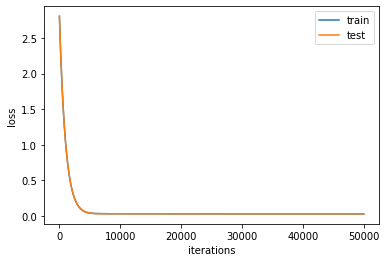

In [415]:
# Вызываем функцию
loss_and_iterations_hist(model)

# ВЫВОД: на графике признаки переобучения отсутствуют.

### Сохраним результаты модели и гиперпараметры в файл для дальнейшего сравнения моделей

In [416]:
model.get_params()

{'iterations': 50000,
 'learning_rate': 0.001,
 'depth': 6,
 'loss_function': <__main__.RMSLE at 0x7f57dd4c3c40>,
 'random_seed': 42,
 'use_best_model': True,
 'verbose': 10,
 'train_dir': 'catboost_clf_modelbaseline_catboost_1_50000iter',
 'eval_metric': <__main__.RMSLE_val at 0x7f57dd4c37f0>,
 'early_stopping_rounds': 50}

In [417]:
# Определяем функцию
def saving_model_metrics_and_hyperparameters(model, test_pool, model_number):
    """МЕТОД СОХРАНЯЕТ ПАРАМЕТРЫ ЗАПУЩЕННОЙ РАНЕЕ МОДЕЛИ И ЕЕ МЕТРИКИ"""
    """задаем директорию"""
    dataset_dir = "Model_metrics_diplom"

    """если ее нет, создаем директорию"""
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    """рассчитываем метрики для модели"""
    test_metrics = model.eval_metrics(
        test_pool,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model.best_iteration_ - 1,
        ntree_end=model.best_iteration_,
        eval_period=1,
        thread_count=-1)

    """добавляем рассчитанные метрики в словарь"""
    file_with_metrics = {}
    file_with_metrics[f'model{model_number}_metrics'] = []
    file_with_metrics[f'model{model_number}_metrics'].append(test_metrics)

#     """добавляем гиперпараметры модели в словарь"""
#     model_parameters = model.get_params()

#     file_with_metrics[f'model{model_number}_hyperparams'] = []
#     file_with_metrics[f'model{model_number}_hyperparams'].append(model_parameters)

    """добавляем метрики и гиперпараметры модели в файл jsonlines"""
    with open('Model_metrics_diplom/file_with_metrics.jsonlines', 'a', encoding='utf-8') as file:
        json.dump(file_with_metrics, file)
        file.write('\n')
        
    return file_with_metrics

In [418]:
#вызываем функцию
model_metrics_and_hyperparameters = saving_model_metrics_and_hyperparameters(model, test_pool, model_number)

In [419]:
model_metrics_and_hyperparameters

{'modelbaseline_catboost_1_50000iter_metrics': [{'RMSE': [0.45669301206242663],
   'MAE': [0.27877939184014333],
   'R2': [0.42038677473636477]}]}

### Сделаем предсказание модели на отложенной выборке (без разметки) и загрузим на kaggle

In [420]:
predictions = np.exp(model.predict(data_checked))
predictions

array([5154611.4225, 8538233.0077, 5196647.8236, ..., 4317502.9127,
       5517545.9543, 9044154.1714])

In [421]:
from sklearn.metrics import mean_squared_log_error
pred = np.exp(model.predict(data_checked))
rmsle = np.sqrt(mean_squared_log_error(data_checked, pred))

print('RMSLE: {:.3f}'.format(rmsle))

ValueError: y_true and y_pred have different number of output (332!=1)

1. Модель не предсказывает, если отличаются столбцы
2. Столбцы отличаются из из one hot encoding
3. Вопрос: как мне получить предсказания модели для проверочного датасета? Проверочный датасет нужно обрабатывать также, как и обучающий?

In [422]:
predict = np.exp(model.predict(data_checked))
submission = pd.DataFrame({'id': id_check, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,"5,154,611.42251"
1,30475,"8,538,233.00768"
2,30476,"5,196,647.82357"
3,30477,"5,940,206.52114"
4,30478,"5,295,185.45121"


In [423]:
submission.to_csv('CatBoost_without_macro_50000iter.csv', index=False)

# Применим алгоритм Random forest

In [424]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

In [425]:
rf_regressor = RandomForestRegressor(n_estimators = 10)  
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
rmse = metrics.root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.4965486336571042


In [426]:
predict_rf = np.exp(rf_regressor.predict(data_checked))
submission_fr = pd.DataFrame({'id': id_check, 'price_doc': predict_rf})
submission.head()

,id,price_doc
0,30474,"5,154,611.42251"
1,30475,"8,538,233.00768"
2,30476,"5,196,647.82357"
3,30477,"5,940,206.52114"
4,30478,"5,295,185.45121"


In [427]:
submission.to_csv('CatBoost_without_macro_rf.csv', index=False)

# Попробуем подобрать параметры сеткой для random forest

In [428]:
# инициализируем модель
model_cv = RandomForestRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    "n_estimators"      : [10, 50,100,150],
     "max_features"      : ["auto", "sqrt", "log2"],
     "min_samples_split" : [2,4,8],
     "bootstrap": [True, False],
     "max_depth" : [5,20]
    }
 
grid_search = GridSearchCV(model_cv, param_grid, n_jobs=-1, cv=5)


grid_search.fit(X_train, y_train)
 
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_) 

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 150}
Best Cross-Validation Score: 0.3815965410675243
Best model: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
                      n_estimators=150, random_state=42)


In [429]:
# Best Hyperparameters: {'bootstrap': True
# , 'max_depth': 20
#     , 'max_features': 'sqrt'
#         , 'min_samples_split': 8
#             , 'n_estimators': 150}
# Best Cross-Validation Score: 0.3815965410675243

In [430]:
# получили лучшую модель
print("Best model:", grid_search.best_estimator_) 

Best model: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
                      n_estimators=150, random_state=42)


In [431]:
# Best model: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
#                       n_estimators=150, random_state=42)

In [432]:
# сделаем предскание подобранной через grid_search модели
predict_rf_grid_search = np.exp(grid_search.best_estimator_.predict(data_checked))
submission_fr_grid_search = pd.DataFrame({'id': id_check, 'price_doc': predict_rf_grid_search})
submission_fr_grid_search.head()

,id,price_doc
0,30474,"5,412,892.49044"
1,30475,"7,857,444.67322"
2,30476,"5,201,755.94274"
3,30477,"5,976,418.52478"
4,30478,"5,359,628.71952"


In [433]:
submission_fr_grid_search.to_csv('CatBoost_without_macro_rf_grid.csv', index=False)

# Еще раз подберем параметры

In [434]:
# инициализируем модель
model_cv_2 = RandomForestRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid_2 = {
    "n_estimators"      : [150, 300, 500],
     "max_features"      : ["sqrt"],
     "min_samples_split" : [8,10,15],
     "bootstrap": [True],
     "max_depth" : [20,30, 50]
    }
 
grid_search_2 = GridSearchCV(model_cv_2, param_grid_2, n_jobs=-1, cv=5)


grid_search_2.fit(X_train, y_train)
 
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", grid_search_2.best_params_)
print("Best Cross-Validation Score:", grid_search_2.best_score_)
print("Best model:", grid_search_2.best_estimator_) 

Best Hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 500}
Best Cross-Validation Score: 0.38384874444434675
Best model: RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=15,
                      n_estimators=500, random_state=42)


In [435]:
# сделаем предскание подобранной через grid_search модели
predict_rf_grid_search2 = np.exp(grid_search_2.best_estimator_.predict(data_checked))
submission_fr_grid_search2 = pd.DataFrame({'id': id_check, 'price_doc': predict_rf_grid_search2})
submission_fr_grid_search2.head()

,id,price_doc
0,30474,"5,290,944.82021"
1,30475,"7,824,225.04544"
2,30476,"5,024,648.58161"
3,30477,"6,020,632.16940"
4,30478,"5,324,189.45569"


In [436]:
submission_fr_grid_search2.to_csv('CatBoost_without_macro_rf_grid2.csv', index=False)

# Попробуем LightGBM

In [437]:
#  создаем датасет для LightGBM
train_data_lgb = lgb.Dataset(X_train, label=y_train) 
test_data_lgb = lgb.Dataset(X_test, label=y_test, reference=train_data_lgb) 

In [438]:
lgb_params = { 
    'task': 'train',
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
    'force_col_wise': True,
    'verbose': -1,
    'early_stopping_rounds': 30
} 

In [439]:
# обучение модели, загрузка данных
model_lgb = lgb.train(lgb_params, train_set=train_data_lgb, valid_sets=test_data_lgb)

In [440]:
y_pred = model_lgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f"% mse)
print("RMSE: %.2f"% rmse)

MSE: 0.21
RMSE: 0.46


In [441]:
# сделаем предскание подобранной через grid_search модели
predict_lgbm = np.exp(model_lgb.predict(data_checked))
submission_lgbm = pd.DataFrame({'id': id_check, 'price_doc': predict_lgbm})
submission_lgbm.head()

,id,price_doc
0,30474,"5,101,454.78146"
1,30475,"8,318,374.72134"
2,30476,"5,277,528.66077"
3,30477,"5,917,938.65503"
4,30478,"5,269,389.71546"


In [442]:
submission_lgbm.to_csv('LGBM_without_macro.csv', index=False)

In [443]:
# метрика схожа с catboost

# Проверим изменение точности модели при сокращении количества фичей методом главных компонент PCA

In [444]:
# Инициализируем PCA
pca = PCA()
# Обучаем PCA на обучающей выборке
pca.fit(X_data)

PCA()

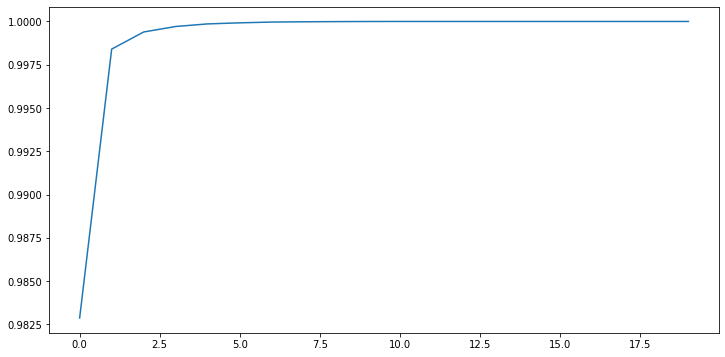

In [445]:
# Строим график, показывающий, какой процент дисперсии объясняется разным количеством компонент PCA
# Применяем метод объясненной дисперсии
# Этот метод заключается в выборе числа компонент так, чтобы доля объясненной дисперсии достигла 
# заданного порога. Это позволяет сохранить большую часть информации при снижении размерности.
plt.figure(figsize=(12,6))
plt.plot(pca.explained_variance_ratio_[:20].cumsum());

In [446]:
# Создадим объект класса PCA с числом компонент, равным 2
pca = PCA(n_components=10)
# Обучим PCA и преобразуем датафрейм при помощи метода fit_transform
X_data_PCA = pca.fit_transform(X_data)

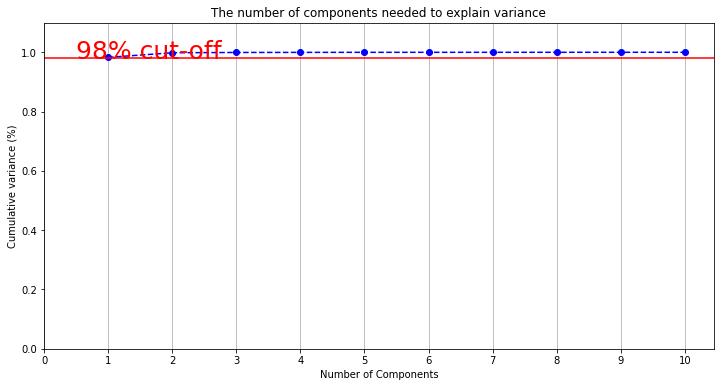

In [447]:
pca = PCA().fit(X_data_PCA)

# % matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(0.5, 0.98, '98% cut-off', color = 'red', fontsize=25)

ax.grid(axis='x')
plt.show()

In [448]:
# Обучим PCA и преобразуем датафрейм при помощи метода fit_transform
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.fit_transform(X_test)

In [449]:
# Приведение данных после PCA к формату pool
train_pool_after_PCA = catboost.Pool(X_train_PCA,label=y_train
                               ,cat_features=cat_features)
test_pool_after_PCA = catboost.Pool(X_test_PCA,label=y_test
                              ,cat_features=cat_features)

In [450]:
# Задаем порядковый номер или название модели "_название"
model_number='catboost_after_PCA_v2'

In [451]:
model_after_PCA = catboost_model_define_and_fit(train_pool_after_PCA
                              ,test_pool_after_PCA
                              ,model_number)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03307240725
bestIteration = 32067

Shrink model to first 32068 iterations.


In [452]:
test_metrics = model_after_PCA.eval_metrics(
        test_pool_after_PCA,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model_after_PCA.best_iteration_ - 1,
        ntree_end=model_after_PCA.best_iteration_,
        eval_period=1,
        thread_count=-1)
test_metrics

{'RMSE': [0.5383499837360377],
 'MAE': [0.40436386719978695],
 'R2': [0.19458639385162102]}

In [453]:
# {'RMSE': [0.6811489880215537],
#  'MAE': [0.5623661098310777],
#  'R2': [-0.276353527903497]}

In [454]:
data_checked_pool = catboost.Pool(data_checked,cat_features=cat_features_checked)

In [455]:
test_metrics = model_after_PCA.eval_metrics(
        test_pool,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model_after_PCA.best_iteration_ - 1,
        ntree_end=model_after_PCA.best_iteration_,
        eval_period=1,
        thread_count=-1)
test_metrics

{'RMSE': [0.943091475029912],
 'MAE': [0.7727528052728558],
 'R2': [-1.4717081621627606]}

In [456]:
# сделаем предскание подобранной через grid_search модели
predict_catboost_after_PCA = np.exp(model_after_PCA.predict(data_checked))
submission_catboost_after_PCA = pd.DataFrame({'id': id_check, 'price_doc': predict_catboost_after_PCA})
submission_catboost_after_PCA.head()

,id,price_doc
0,30474,"11,446,359.39266"
1,30475,"11,699,354.14676"
2,30476,"11,797,597.52385"
3,30477,"13,480,238.80334"
4,30478,"11,640,821.67446"


In [457]:
submission_catboost_after_PCA.to_csv('Catboost_after_PCA.csv', index=False)

## Вывод: точность существенно упала, метод главных компонент не подходит для этой задачи.

In [458]:
table_score = pd.read_csv('/home/sigma.sbrf.ru@19229892/Загрузки/sberbank-russian-housing-market-privateleaderboard-2024-11-10T15_31_46/sberbank-russian-housing-market-privateleaderboard-2024-11-10T15:31:46.csv')

In [459]:
table_score

,Rank,TeamId,TeamName,LastSubmissionDate,Score,SubmissionCount,TeamMemberUserNames
0,1,640447,alijs & Evgeny,2017-06-29 17:50:18,0.30087,311,"alijs1,johnpateha"
1,2,689420,data_mining2,2017-06-29 22:54:10,0.30925,151,datamining2
2,3,647805,Computer says no,2017-06-29 22:18:48,0.31032,110,gphilippis
3,4,651738,Sher Dil,2017-06-29 06:54:20,0.31073,153,"divyanshusuri,mayank14"
4,5,685084,Patrick_,2017-06-29 09:38:29,0.31104,131,sjshao09
...,...,...,...,...,...,...,...
3260,3260,684417,Walker Güke,2017-06-18 17:46:09,10.38593,1,carsongoeke
3261,3261,641570,Peter,2017-06-28 07:08:50,10.57384,62,petermazurkin
3262,3262,758230,Andrey Vykhodtsev,2017-06-27 22:24:27,11.77919,1,vykhand
3263,3263,686934,Feng Li,2017-06-29 18:45:58,11.78082,1,fengliplatform


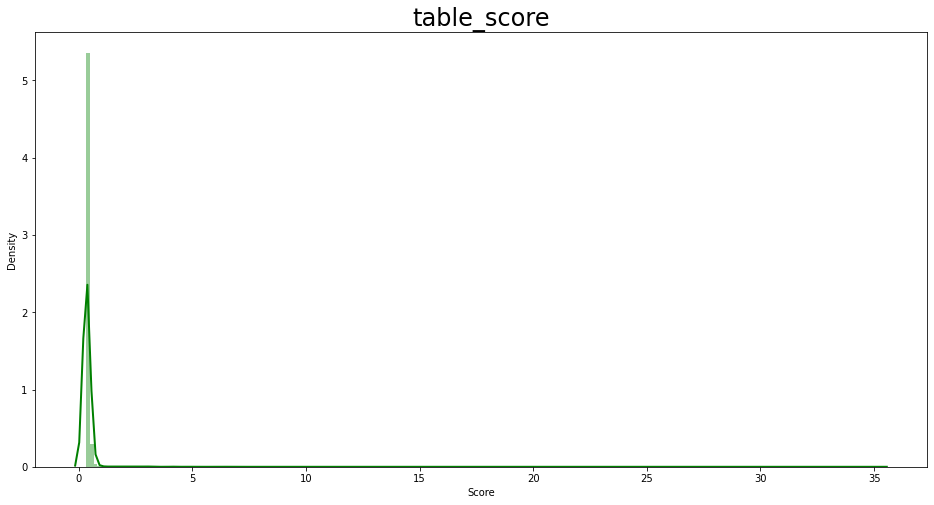

In [460]:
# Построим гистограмму распределения по столбцу Score
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(table_score['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )
plt.title('table_score', fontsize=24)
plt.show()

In [461]:
# Уберём выбросы и сделаем график нагляднее
t_s = table_score[table_score['Score'] < 0.345]

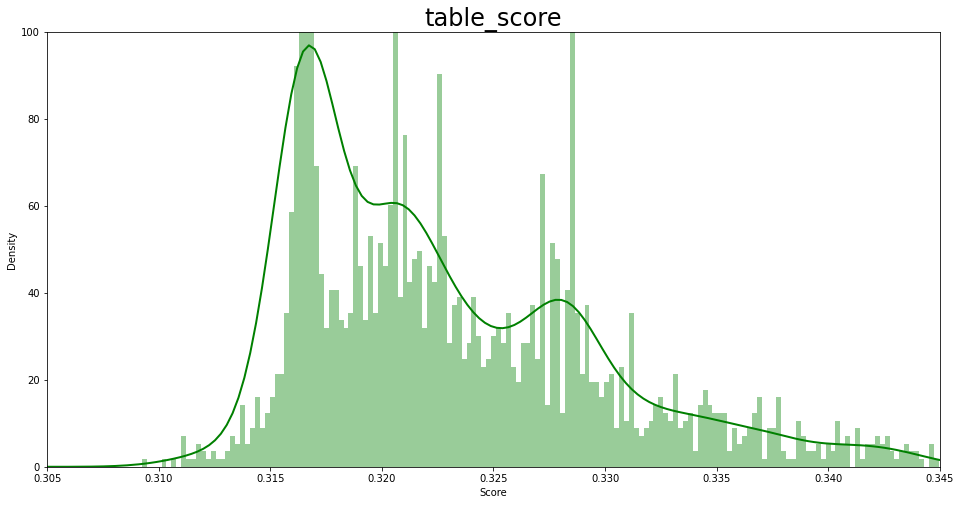

In [462]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(t_s['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )

plt.xlim(0.305,0.345), 
plt.ylim(0,100)

plt.title('table_score', fontsize=24)
plt.show()

In [463]:
# Добавим лучший получившийся результат на график распредлеления Score
best_res = 0.320

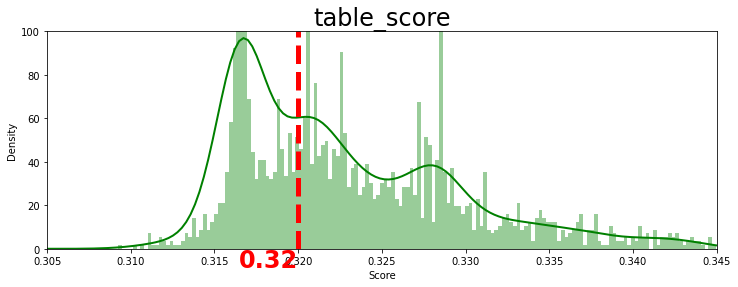

In [464]:
fig, ax = plt.subplots(figsize=(12,4))
sns.distplot(t_s['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )
plt.axvline(x=best_res, color='red', linestyle='--', label='Threshold', linewidth=5)
ax.text(best_res, 0.5, best_res, color='r', fontsize=24,
        ha='right', va='top', fontweight='bold')

plt.xlim(0.305,0.345), 
plt.ylim(0,100)

plt.title('table_score', fontsize=24)
plt.show()

# Вывод: все алгоритмы очень похоже справились с задачей регрессии. Чуть лучше остальных был CatBoost. 